In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 5

# Size of data split for testing
train_size = 0.8

In [6]:
index = []

for i in range(days):
    index.append(np.arange(i,len(data),days))

In [7]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(len(index)):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [8]:
# Normalise data
normaliser = preprocessing.MinMaxScaler()
data_norm = normaliser.fit_transform(data)

In [9]:
# Normalised chunks
historical_sequences_norm = np.array([data_norm[ix].copy() for ix in ordered_index])
next_day_open_values_norm = np.array([data_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
next_day_open_values_norm = np.expand_dims(next_day_open_values_norm, -1)

In [10]:
# Delete those sequences that doesn't have a -th day in the results
historical_sequences_norm = historical_sequences_norm[:next_day_open_values_norm.shape[0]]

In [11]:
historical_sequences_norm.shape

(4755, 92, 5)

In [12]:
next_day_open_values_norm.shape

(4755, 1)

In [13]:
# Y raw data
next_day_open_values = np.array([data.to_numpy()[ordered_index[i+days][-1],0] for i in range(len(ordered_index) - days)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit_transform(next_day_open_values)

array([[0.32507933],
       [0.31792447],
       [0.29925963],
       ...,
       [0.47601568],
       [0.44328999],
       [0.46319915]])

In [14]:
# Train-Test split
split = int(historical_sequences_norm.shape[0] * train_size)

X_train = historical_sequences_norm[:split]
Y_train = next_day_open_values_norm[:split]

X_test = historical_sequences_norm[split:]
Y_test = next_day_open_values_norm[split:]
unscaled_y_test = next_day_open_values[split:]

# Model selection

##### Model constructor

In [15]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [16]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [17]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [18]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 2s 628us/step - loss: 0.0766 - val_loss: 0.0120
Epoch 2/24
3423/3423 [==============================] - 1s 308us/step - loss: 0.0099 - val_loss: 0.0031
Epoch 3/24
3423/3423 [==============================] - 1s 300us/step - loss: 0.0050 - val_loss: 0.0034
Epoch 4/24
3423/3423 [==============================] - 1s 302us/step - loss: 0.0036 - val_loss: 0.0040
Epoch 5/24
3423/3423 [==============================] - 1s 316us/step - loss: 0.0027 - val_loss: 0.0031
Epoch 6/24
3423/3423 [==============================] - 1s 318us/step - loss: 0.0024 - val_loss: 0.0045
Epoch 7/24
3423/3423 [==============================] - 1s 310us/step - loss: 0.0023 - val_loss: 0.0030
Epoch 8/24
3423/3423 [==============================] - 1s 317us/step - loss: 0.0022 - val

3423/3423 [==============================] - 1s 350us/step - loss: 0.0013 - val_loss: 0.0021
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 2s 639us/step - loss: 0.4105 - val_loss: 0.0097
Epoch 2/24
3423/3423 [==============================] - 1s 364us/step - loss: 0.1019 - val_loss: 0.1534
Epoch 3/24
3423/3423 [==============================] - 1s 364us/step - loss: 0.0884 - val_loss: 0.0062
Epoch 4/24
3423/3423 [==============================] - 1s 366us/step - loss: 0.0755 - val_loss: 0.0126
Epoch 5/24
3423/3423 [==============================] - 1s 371us/step - loss: 0.0273 - val_loss: 0.0419
Epoch 6/24
3423/3423 [==============================] - 1s 367us/step - loss: 0.0129 - val_loss: 0.0306
Epoch 7/24
3423/3423 [==============================] - 1s 365us/step - loss: 0.0071 - val_loss: 0.0128
Epoch 8/24
3423/3423 [==============================] - 1s 365us/step - loss: 0.0063 - val_loss: 0.0095
Epoch 9/24
3423/3423 [======

3423/3423 [==============================] - 1s 365us/step - loss: 0.0065 - val_loss: 0.0145
Epoch 5/24
3423/3423 [==============================] - 1s 366us/step - loss: 0.0052 - val_loss: 0.0027
Epoch 6/24
3423/3423 [==============================] - 1s 366us/step - loss: 0.0045 - val_loss: 0.0061
Epoch 7/24
3423/3423 [==============================] - 1s 365us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 8/24
3423/3423 [==============================] - 1s 364us/step - loss: 0.0038 - val_loss: 0.0042
Epoch 9/24
3423/3423 [==============================] - 1s 367us/step - loss: 0.0035 - val_loss: 0.0043
Epoch 10/24
3423/3423 [==============================] - 1s 366us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 11/24
3423/3423 [==============================] - 1s 368us/step - loss: 0.0033 - val_loss: 0.0043
Epoch 12/24
3423/3423 [==============================] - 1s 366us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 13/24
3423/3423 [==============================] - 1s 364us/step -

3423/3423 [==============================] - 1s 367us/step - loss: 0.0028 - val_loss: 0.0022
Epoch 10/24
3423/3423 [==============================] - 1s 371us/step - loss: 0.0059 - val_loss: 0.0133
Epoch 11/24
3423/3423 [==============================] - 1s 367us/step - loss: 0.0061 - val_loss: 0.0026
Epoch 12/24
3423/3423 [==============================] - 1s 367us/step - loss: 0.0033 - val_loss: 0.0067
Epoch 13/24
3423/3423 [==============================] - 1s 366us/step - loss: 0.0036 - val_loss: 0.0028
Epoch 14/24
3423/3423 [==============================] - 1s 367us/step - loss: 0.0038 - val_loss: 0.0085
Epoch 15/24
3423/3423 [==============================] - 1s 365us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 16/24
3423/3423 [==============================] - 1s 363us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 17/24
3423/3423 [==============================] - 1s 367us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 18/24
3423/3423 [==============================] - 1s 364us/s

Epoch 14/24
3423/3423 [==============================] - 1s 339us/step - loss: 0.0020 - val_loss: 0.0031
Epoch 15/24
3423/3423 [==============================] - 1s 336us/step - loss: 0.0019 - val_loss: 0.0025
Epoch 16/24
3423/3423 [==============================] - 1s 336us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 17/24
3423/3423 [==============================] - 1s 336us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 18/24
3423/3423 [==============================] - 1s 335us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 19/24
3423/3423 [==============================] - 1s 335us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 20/24
3423/3423 [==============================] - 1s 337us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 21/24
3423/3423 [==============================] - 1s 335us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 22/24
3423/3423 [==============================] - 1s 336us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 23/24
3423/3423 [==============================] 

Epoch 19/24
3423/3423 [==============================] - 1s 374us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 20/24
3423/3423 [==============================] - 1s 375us/step - loss: 0.0018 - val_loss: 0.0024
Epoch 21/24
3423/3423 [==============================] - 1s 374us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 22/24
3423/3423 [==============================] - 1s 381us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 23/24
3423/3423 [==============================] - 1s 375us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 24/24
3423/3423 [==============================] - 1s 375us/step - loss: 0.0017 - val_loss: 0.0023
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 3s 919us/step - loss: 0.0765 - val_loss: 0.0235
Epoch 2/24
3423/3423 [==============================] - 1s 392us/step - loss: 0.0192 - val_loss: 0.0139
Epoch 3/24
3423/3423 [==============================] - 1s 392us/step - loss: 0.0104 - val_loss: 0.0041
Epoch 4/24


Epoch 24/24
3423/3423 [==============================] - 1s 370us/step - loss: 0.0034 - val_loss: 0.0043

GENERATION 2

Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 3s 1000us/step - loss: 2.0825 - val_loss: 0.0031
Epoch 2/24
3423/3423 [==============================] - 1s 435us/step - loss: 0.0043 - val_loss: 0.0029
Epoch 3/24
3423/3423 [==============================] - 1s 434us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 4/24
3423/3423 [==============================] - 1s 436us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 5/24
3423/3423 [==============================] - 1s 434us/step - loss: 0.0021 - val_loss: 0.0038
Epoch 6/24
3423/3423 [==============================] - 1s 433us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 7/24
3423/3423 [==============================] - 2s 440us/step - loss: 0.0023 - val_loss: 0.0040
Epoch 8/24
3423/3423 [==============================] - 1s 433us/step - loss: 0.0033 - val_loss: 0.0040


3423/3423 [==============================] - 1s 342us/step - loss: 0.0035 - val_loss: 0.0069
Epoch 5/24
3423/3423 [==============================] - 1s 342us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/24
3423/3423 [==============================] - 1s 344us/step - loss: 0.0025 - val_loss: 0.0056
Epoch 7/24
3423/3423 [==============================] - 1s 341us/step - loss: 0.0023 - val_loss: 0.0029
Epoch 8/24
3423/3423 [==============================] - 1s 342us/step - loss: 0.0023 - val_loss: 0.0043
Epoch 9/24
3423/3423 [==============================] - 1s 343us/step - loss: 0.0022 - val_loss: 0.0033
Epoch 10/24
3423/3423 [==============================] - 1s 344us/step - loss: 0.0022 - val_loss: 0.0037
Epoch 11/24
3423/3423 [==============================] - 1s 349us/step - loss: 0.0021 - val_loss: 0.0035
Epoch 12/24
3423/3423 [==============================] - 1s 343us/step - loss: 0.0021 - val_loss: 0.0034
Epoch 13/24
3423/3423 [==============================] - 1s 342us/step -

3423/3423 [==============================] - 1s 344us/step - loss: 0.0048 - val_loss: 0.0100
Epoch 10/24
3423/3423 [==============================] - 1s 343us/step - loss: 0.0058 - val_loss: 0.0063
Epoch 11/24
3423/3423 [==============================] - 1s 343us/step - loss: 0.0067 - val_loss: 0.0137
Epoch 12/24
3423/3423 [==============================] - 1s 345us/step - loss: 0.0077 - val_loss: 0.0050
Epoch 13/24
3423/3423 [==============================] - 1s 343us/step - loss: 0.0059 - val_loss: 0.0122
Epoch 14/24
3423/3423 [==============================] - 1s 346us/step - loss: 0.0057 - val_loss: 0.0058
Epoch 15/24
3423/3423 [==============================] - 1s 345us/step - loss: 0.0058 - val_loss: 0.0117
Epoch 16/24
3423/3423 [==============================] - 1s 346us/step - loss: 0.0050 - val_loss: 0.0040
Epoch 17/24
3423/3423 [==============================] - 1s 352us/step - loss: 0.0050 - val_loss: 0.0131
Epoch 18/24
3423/3423 [==============================] - 1s 346us/s

Epoch 14/24
3423/3423 [==============================] - 2s 517us/step - loss: 0.0109 - val_loss: 0.0205
Epoch 15/24
3423/3423 [==============================] - 2s 514us/step - loss: 0.0060 - val_loss: 0.0059
Epoch 16/24
3423/3423 [==============================] - 2s 513us/step - loss: 0.0067 - val_loss: 0.0184
Epoch 17/24
3423/3423 [==============================] - 2s 512us/step - loss: 0.0093 - val_loss: 0.0168
Epoch 18/24
3423/3423 [==============================] - 2s 515us/step - loss: 0.0070 - val_loss: 0.0117
Epoch 19/24
3423/3423 [==============================] - 2s 520us/step - loss: 0.0055 - val_loss: 0.0090
Epoch 20/24
3423/3423 [==============================] - 2s 513us/step - loss: 0.0074 - val_loss: 0.0169
Epoch 21/24
3423/3423 [==============================] - 2s 515us/step - loss: 0.0051 - val_loss: 0.0041
Epoch 22/24
3423/3423 [==============================] - 2s 515us/step - loss: 0.0069 - val_loss: 0.0178
Epoch 23/24
3423/3423 [==============================] 

Epoch 19/24
3423/3423 [==============================] - 1s 354us/step - loss: 0.0027 - val_loss: 0.0071
Epoch 20/24
3423/3423 [==============================] - 1s 354us/step - loss: 0.0026 - val_loss: 0.0078
Epoch 21/24
3423/3423 [==============================] - 1s 355us/step - loss: 0.0024 - val_loss: 0.0084
Epoch 22/24
3423/3423 [==============================] - 1s 353us/step - loss: 0.0025 - val_loss: 0.0094
Epoch 23/24
3423/3423 [==============================] - 1s 356us/step - loss: 0.0023 - val_loss: 0.0091
Epoch 24/24
3423/3423 [==============================] - 1s 355us/step - loss: 0.0022 - val_loss: 0.0109
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 5s 1ms/step - loss: 0.0889 - val_loss: 0.0085
Epoch 2/24
3423/3423 [==============================] - 2s 478us/step - loss: 0.0117 - val_loss: 0.0168
Epoch 3/24
3423/3423 [==============================] - 2s 476us/step - loss: 0.0064 - val_loss: 0.0041
Epoch 4/24
34

3423/3423 [==============================] - 2s 527us/step - loss: nan - val_loss: nan
Epoch 3/24
3423/3423 [==============================] - 2s 525us/step - loss: nan - val_loss: nan
Epoch 4/24
3423/3423 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Epoch 5/24
3423/3423 [==============================] - 2s 528us/step - loss: nan - val_loss: nan
Epoch 6/24
3423/3423 [==============================] - 2s 532us/step - loss: nan - val_loss: nan
Epoch 7/24
3423/3423 [==============================] - 2s 527us/step - loss: nan - val_loss: nan
Epoch 8/24
3423/3423 [==============================] - 2s 529us/step - loss: nan - val_loss: nan
Epoch 9/24
3423/3423 [==============================] - 2s 526us/step - loss: nan - val_loss: nan
Epoch 10/24
3423/3423 [==============================] - 2s 527us/step - loss: nan - val_loss: nan
Epoch 11/24
3423/3423 [==============================] - 2s 527us/step - loss: nan - val_loss: nan
Epoch 12/24
3423/3423 [======

3423/3423 [==============================] - 2s 457us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 22/24
3423/3423 [==============================] - 2s 458us/step - loss: 0.0033 - val_loss: 0.0037
Epoch 23/24
3423/3423 [==============================] - 2s 458us/step - loss: 0.0032 - val_loss: 0.0046
Epoch 24/24
3423/3423 [==============================] - 2s 457us/step - loss: 0.0030 - val_loss: 0.0041
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 6s 2ms/step - loss: 0.1232 - val_loss: 0.0065
Epoch 2/24
3423/3423 [==============================] - 2s 440us/step - loss: 0.0148 - val_loss: 0.0168
Epoch 3/24
3423/3423 [==============================] - 1s 438us/step - loss: 0.0063 - val_loss: 0.0041
Epoch 4/24
3423/3423 [==============================] - 2s 440us/step - loss: 0.0035 - val_loss: 0.0043
Epoch 5/24
3423/3423 [==============================] - 1s 436us/step - loss: 0.0029 - val_loss: 0.0036
Epoch 6/24
3423/3423 [=====

3423/3423 [==============================] - 6s 2ms/step - loss: 0.0858 - val_loss: 0.0390
Epoch 2/24
3423/3423 [==============================] - 1s 379us/step - loss: 0.0182 - val_loss: 0.0103
Epoch 3/24
3423/3423 [==============================] - 1s 379us/step - loss: 0.0095 - val_loss: 0.0029
Epoch 4/24
3423/3423 [==============================] - 1s 378us/step - loss: 0.0066 - val_loss: 0.0047
Epoch 5/24
3423/3423 [==============================] - 1s 379us/step - loss: 0.0055 - val_loss: 0.0036
Epoch 6/24
3423/3423 [==============================] - 1s 380us/step - loss: 0.0047 - val_loss: 0.0030
Epoch 7/24
3423/3423 [==============================] - 1s 379us/step - loss: 0.0042 - val_loss: 0.0047
Epoch 8/24
3423/3423 [==============================] - 1s 378us/step - loss: 0.0040 - val_loss: 0.0027
Epoch 9/24
3423/3423 [==============================] - 1s 380us/step - loss: 0.0037 - val_loss: 0.0045
Epoch 10/24
3423/3423 [==============================] - 1s 383us/step - loss

3423/3423 [==============================] - 1s 381us/step - loss: nan - val_loss: nan
Epoch 7/24
3423/3423 [==============================] - 1s 386us/step - loss: nan - val_loss: nan
Epoch 8/24
3423/3423 [==============================] - 1s 382us/step - loss: nan - val_loss: nan
Epoch 9/24
3423/3423 [==============================] - 1s 378us/step - loss: nan - val_loss: nan
Epoch 10/24
3423/3423 [==============================] - 1s 380us/step - loss: nan - val_loss: nan
Epoch 11/24
3423/3423 [==============================] - 1s 383us/step - loss: nan - val_loss: nan
Epoch 12/24
3423/3423 [==============================] - 1s 379us/step - loss: nan - val_loss: nan
Epoch 13/24
3423/3423 [==============================] - 1s 379us/step - loss: nan - val_loss: nan
Epoch 14/24
3423/3423 [==============================] - 1s 380us/step - loss: nan - val_loss: nan
Epoch 15/24
3423/3423 [==============================] - 1s 380us/step - loss: nan - val_loss: nan
Epoch 16/24
3423/3423 [==

3423/3423 [==============================] - 2s 446us/step - loss: 0.0019 - val_loss: 0.0026
Epoch 14/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0018 - val_loss: 0.0026
Epoch 15/24
3423/3423 [==============================] - 2s 444us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 16/24
3423/3423 [==============================] - 2s 439us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 17/24
3423/3423 [==============================] - 2s 441us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 18/24
3423/3423 [==============================] - 2s 439us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 19/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 20/24
3423/3423 [==============================] - 2s 440us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 21/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 22/24
3423/3423 [==============================] - 2s 439us/s

3423/3423 [==============================] - 2s 465us/step - loss: 0.0029 - val_loss: 0.0138
Epoch 19/24
3423/3423 [==============================] - 2s 464us/step - loss: 0.0032 - val_loss: 0.0112
Epoch 20/24
3423/3423 [==============================] - 2s 463us/step - loss: 0.0027 - val_loss: 0.0101
Epoch 21/24
3423/3423 [==============================] - 2s 464us/step - loss: 0.0024 - val_loss: 0.0040
Epoch 22/24
3423/3423 [==============================] - 2s 465us/step - loss: 0.0020 - val_loss: 0.0049
Epoch 23/24
3423/3423 [==============================] - 2s 464us/step - loss: 0.0019 - val_loss: 0.0060
Epoch 24/24
3423/3423 [==============================] - 2s 466us/step - loss: 0.0018 - val_loss: 0.0029
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 8s 2ms/step - loss: 1.2078 - val_loss: 0.7645
Epoch 2/24
3423/3423 [==============================] - 2s 462us/step - loss: 0.3570 - val_loss: 0.1948
Epoch 3/24
3423/3423 [==

3423/3423 [==============================] - 2s 464us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 24/24
3423/3423 [==============================] - 2s 463us/step - loss: 0.0019 - val_loss: 0.0025
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 8s 2ms/step - loss: 0.1606 - val_loss: 0.0166
Epoch 2/24
3423/3423 [==============================] - 1s 325us/step - loss: 0.0127 - val_loss: 0.0357
Epoch 3/24
3423/3423 [==============================] - 1s 323us/step - loss: 0.0153 - val_loss: 0.0060
Epoch 4/24
3423/3423 [==============================] - 1s 323us/step - loss: 0.0042 - val_loss: 0.0067
Epoch 5/24
3423/3423 [==============================] - 1s 323us/step - loss: 0.0051 - val_loss: 0.0176
Epoch 6/24
3423/3423 [==============================] - 1s 323us/step - loss: 0.0129 - val_loss: 0.0100
Epoch 7/24
3423/3423 [==============================] - 1s 323us/step - loss: 0.0039 - val_loss: 0.0048
Epoch 8/24
3423/3423 [=======

3423/3423 [==============================] - 2s 441us/step - loss: 0.0051 - val_loss: 0.0065
Epoch 4/24
3423/3423 [==============================] - 2s 441us/step - loss: 0.0036 - val_loss: 0.0038
Epoch 5/24
3423/3423 [==============================] - 2s 444us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 6/24
3423/3423 [==============================] - 2s 443us/step - loss: 0.0026 - val_loss: 0.0050
Epoch 7/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/24
3423/3423 [==============================] - 2s 448us/step - loss: 0.0022 - val_loss: 0.0029
Epoch 9/24
3423/3423 [==============================] - 2s 444us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 10/24
3423/3423 [==============================] - 2s 443us/step - loss: 0.0020 - val_loss: 0.0031
Epoch 11/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0020 - val_loss: 0.0029
Epoch 12/24
3423/3423 [==============================] - 2s 441us/step - 

3423/3423 [==============================] - 1s 404us/step - loss: 0.0087 - val_loss: 0.0090
Epoch 9/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0050 - val_loss: 0.0043
Epoch 10/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0035 - val_loss: 0.0063
Epoch 11/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0078 - val_loss: 0.0103
Epoch 12/24
3423/3423 [==============================] - 1s 403us/step - loss: 0.0058 - val_loss: 0.0065
Epoch 13/24
3423/3423 [==============================] - 1s 410us/step - loss: 0.0036 - val_loss: 0.0045
Epoch 14/24
3423/3423 [==============================] - 1s 407us/step - loss: 0.0047 - val_loss: 0.0152
Epoch 15/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0089 - val_loss: 0.0030
Epoch 16/24
3423/3423 [==============================] - 1s 403us/step - loss: 0.0035 - val_loss: 0.0059
Epoch 17/24
3423/3423 [==============================] - 1s 404us/st

3423/3423 [==============================] - 1s 408us/step - loss: 0.0107 - val_loss: 0.0360
Epoch 13/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0188 - val_loss: 0.0070
Epoch 14/24
3423/3423 [==============================] - 1s 409us/step - loss: 0.0115 - val_loss: 0.0376
Epoch 15/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0142 - val_loss: 0.0083
Epoch 16/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0102 - val_loss: 0.0253
Epoch 17/24
3423/3423 [==============================] - 1s 403us/step - loss: 0.0121 - val_loss: 0.0269
Epoch 18/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0199 - val_loss: 0.0294
Epoch 19/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0088 - val_loss: 0.0079
Epoch 20/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0082 - val_loss: 0.0230
Epoch 21/24
3423/3423 [==============================] - 1s 405us/s

Epoch 17/24
3423/3423 [==============================] - 2s 441us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 18/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 19/24
3423/3423 [==============================] - 2s 441us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 20/24
3423/3423 [==============================] - 2s 440us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 21/24
3423/3423 [==============================] - 2s 440us/step - loss: 0.0016 - val_loss: 0.0020
Epoch 22/24
3423/3423 [==============================] - 2s 445us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 23/24
3423/3423 [==============================] - 2s 448us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 24/24
3423/3423 [==============================] - 2s 441us/step - loss: 0.0014 - val_loss: 0.0019
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 11s 3ms/step - loss: 0.1409 - val_loss: 0.0398
Epoch 2/24

Epoch 22/24
3423/3423 [==============================] - 2s 445us/step - loss: 0.0040 - val_loss: 0.0099
Epoch 23/24
3423/3423 [==============================] - 2s 445us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 24/24
3423/3423 [==============================] - 2s 444us/step - loss: 0.0021 - val_loss: 0.0077
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 12s 3ms/step - loss: 0.1393 - val_loss: 0.0052
Epoch 2/24
3423/3423 [==============================] - 2s 448us/step - loss: 0.0088 - val_loss: 0.0463
Epoch 3/24
3423/3423 [==============================] - 2s 447us/step - loss: 0.0179 - val_loss: 0.0093
Epoch 4/24
3423/3423 [==============================] - 2s 446us/step - loss: 0.0087 - val_loss: 0.0173
Epoch 5/24
3423/3423 [==============================] - 2s 447us/step - loss: 0.0053 - val_loss: 0.0084
Epoch 6/24
3423/3423 [==============================] - 2s 448us/step - loss: 0.0082 - val_loss: 0.0168
Epoch 7/24
3423

3423/3423 [==============================] - 2s 443us/step - loss: 0.0160 - val_loss: 0.0184
Epoch 3/24
3423/3423 [==============================] - 2s 443us/step - loss: 0.0069 - val_loss: 0.0052
Epoch 4/24
3423/3423 [==============================] - 2s 444us/step - loss: 0.0040 - val_loss: 0.0126
Epoch 5/24
3423/3423 [==============================] - 2s 444us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 6/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0026 - val_loss: 0.0066
Epoch 7/24
3423/3423 [==============================] - 2s 448us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/24
3423/3423 [==============================] - 2s 441us/step - loss: 0.0021 - val_loss: 0.0046
Epoch 9/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0020 - val_loss: 0.0026
Epoch 10/24
3423/3423 [==============================] - 2s 443us/step - loss: 0.0019 - val_loss: 0.0034
Epoch 11/24
3423/3423 [==============================] - 2s 443us/step - l

3423/3423 [==============================] - 2s 451us/step - loss: 0.0057 - val_loss: 0.0521
Epoch 8/24
3423/3423 [==============================] - 2s 449us/step - loss: 0.0057 - val_loss: 0.0379
Epoch 9/24
3423/3423 [==============================] - 2s 449us/step - loss: 0.0055 - val_loss: 0.0417
Epoch 10/24
3423/3423 [==============================] - 2s 450us/step - loss: 0.0054 - val_loss: 0.0375
Epoch 11/24
3423/3423 [==============================] - 2s 448us/step - loss: 0.0054 - val_loss: 0.0237
Epoch 12/24
3423/3423 [==============================] - 2s 451us/step - loss: 0.0054 - val_loss: 0.0355
Epoch 13/24
3423/3423 [==============================] - 2s 452us/step - loss: 0.0052 - val_loss: 0.0324
Epoch 14/24
3423/3423 [==============================] - 2s 450us/step - loss: 0.0051 - val_loss: 0.0238
Epoch 15/24
3423/3423 [==============================] - 2s 467us/step - loss: 0.0051 - val_loss: 0.0303
Epoch 16/24
3423/3423 [==============================] - 2s 456us/ste

3423/3423 [==============================] - 1s 391us/step - loss: 0.0054 - val_loss: 0.0253
Epoch 13/24
3423/3423 [==============================] - 1s 396us/step - loss: 0.0055 - val_loss: 0.0061
Epoch 14/24
3423/3423 [==============================] - 1s 388us/step - loss: 0.0052 - val_loss: 0.0302
Epoch 15/24
3423/3423 [==============================] - 1s 387us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 16/24
3423/3423 [==============================] - 1s 388us/step - loss: 0.0044 - val_loss: 0.0119
Epoch 17/24
3423/3423 [==============================] - 1s 388us/step - loss: 0.0045 - val_loss: 0.0189
Epoch 18/24
3423/3423 [==============================] - 1s 390us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 19/24
3423/3423 [==============================] - 1s 390us/step - loss: 0.0049 - val_loss: 0.0187
Epoch 20/24
3423/3423 [==============================] - 1s 390us/step - loss: 0.0050 - val_loss: 0.0059
Epoch 21/24
3423/3423 [==============================] - 1s 390us/s

Epoch 17/24
3423/3423 [==============================] - 1s 374us/step - loss: 0.0059 - val_loss: 0.0040
Epoch 18/24
3423/3423 [==============================] - 1s 376us/step - loss: 0.0057 - val_loss: 0.0227
Epoch 19/24
3423/3423 [==============================] - 1s 375us/step - loss: 0.0070 - val_loss: 0.0045
Epoch 20/24
3423/3423 [==============================] - 1s 373us/step - loss: 0.0043 - val_loss: 0.0106
Epoch 21/24
3423/3423 [==============================] - 1s 381us/step - loss: 0.0055 - val_loss: 0.0041
Epoch 22/24
3423/3423 [==============================] - 1s 375us/step - loss: 0.0046 - val_loss: 0.0255
Epoch 23/24
3423/3423 [==============================] - 1s 376us/step - loss: 0.0057 - val_loss: 0.0055
Epoch 24/24
3423/3423 [==============================] - 1s 372us/step - loss: 0.0039 - val_loss: 0.0135
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 14s 4ms/step - loss: 0.0753 - val_loss: 0.0323
Epoch 2/24

Epoch 22/24
3423/3423 [==============================] - 2s 458us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 23/24
3423/3423 [==============================] - 2s 454us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 24/24
3423/3423 [==============================] - 2s 451us/step - loss: 0.0012 - val_loss: 0.0018
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 15s 4ms/step - loss: 0.0448 - val_loss: 0.0031
Epoch 2/24
3423/3423 [==============================] - 2s 454us/step - loss: 0.0068 - val_loss: 0.0045
Epoch 3/24
3423/3423 [==============================] - 2s 453us/step - loss: 0.0057 - val_loss: 0.0143
Epoch 4/24
3423/3423 [==============================] - 2s 450us/step - loss: 0.0039 - val_loss: 0.0026
Epoch 5/24
3423/3423 [==============================] - 2s 451us/step - loss: 0.0029 - val_loss: 0.0047
Epoch 6/24
3423/3423 [==============================] - 2s 450us/step - loss: 0.0025 - val_loss: 0.0042
Epoch 7/24
3423

3423/3423 [==============================] - 2s 502us/step - loss: nan - val_loss: nan
Epoch 6/24
3423/3423 [==============================] - 2s 501us/step - loss: nan - val_loss: nan
Epoch 7/24
3423/3423 [==============================] - 2s 503us/step - loss: nan - val_loss: nan
Epoch 8/24
3423/3423 [==============================] - 2s 501us/step - loss: nan - val_loss: nan
Epoch 9/24
3423/3423 [==============================] - 2s 504us/step - loss: nan - val_loss: nan
Epoch 10/24
3423/3423 [==============================] - 2s 502us/step - loss: nan - val_loss: nan
Epoch 11/24
3423/3423 [==============================] - 2s 500us/step - loss: nan - val_loss: nan
Epoch 12/24
3423/3423 [==============================] - 2s 503us/step - loss: nan - val_loss: nan
Epoch 13/24
3423/3423 [==============================] - 2s 502us/step - loss: nan - val_loss: nan
Epoch 14/24
3423/3423 [==============================] - 2s 501us/step - loss: nan - val_loss: nan
Epoch 15/24
3423/3423 [===

3423/3423 [==============================] - 2s 468us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 13/24
3423/3423 [==============================] - 2s 455us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 14/24
3423/3423 [==============================] - 2s 456us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 15/24
3423/3423 [==============================] - 2s 461us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 16/24
3423/3423 [==============================] - 2s 454us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 17/24
3423/3423 [==============================] - 2s 452us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 18/24
3423/3423 [==============================] - 2s 452us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 19/24
3423/3423 [==============================] - 2s 455us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 20/24
3423/3423 [==============================] - 2s 455us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 21/24
3423/3423 [==============================] - 2s 455us/s

3423/3423 [==============================] - 1s 413us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 18/24
3423/3423 [==============================] - 1s 420us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 19/24
3423/3423 [==============================] - 1s 413us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 20/24
3423/3423 [==============================] - 1s 414us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 21/24
3423/3423 [==============================] - 1s 414us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 22/24
3423/3423 [==============================] - 1s 411us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 23/24
3423/3423 [==============================] - 1s 415us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 24/24
3423/3423 [==============================] - 1s 413us/step - loss: 0.0012 - val_loss: 0.0018
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 18s 5ms/step - loss: 0.6760 - val_loss: 0.3483
Epoch 2/24
3423/3423 [

3423/3423 [==============================] - 1s 432us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 24/24
3423/3423 [==============================] - 1s 432us/step - loss: 0.0027 - val_loss: 0.0049
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 18s 5ms/step - loss: 2.2214 - val_loss: 0.7583
Epoch 2/24
3423/3423 [==============================] - 1s 436us/step - loss: 0.2594 - val_loss: 0.0229
Epoch 3/24
3423/3423 [==============================] - 1s 430us/step - loss: 0.1260 - val_loss: 0.0534
Epoch 4/24
3423/3423 [==============================] - 1s 431us/step - loss: 0.0897 - val_loss: 0.0928
Epoch 5/24
3423/3423 [==============================] - 1s 431us/step - loss: 0.0814 - val_loss: 0.0255
Epoch 6/24
3423/3423 [==============================] - 1s 436us/step - loss: 0.0763 - val_loss: 0.0165
Epoch 7/24
3423/3423 [==============================] - 1s 430us/step - loss: 0.0743 - val_loss: 0.0387
Epoch 8/24
3423/3423 [======

3423/3423 [==============================] - 2s 460us/step - loss: 0.0083 - val_loss: 0.0076
Epoch 4/24
3423/3423 [==============================] - 2s 454us/step - loss: 0.0056 - val_loss: 0.0070
Epoch 5/24
3423/3423 [==============================] - 2s 456us/step - loss: 0.0036 - val_loss: 0.0027
Epoch 6/24
3423/3423 [==============================] - 2s 457us/step - loss: 0.0029 - val_loss: 0.0038
Epoch 7/24
3423/3423 [==============================] - 2s 455us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 8/24
3423/3423 [==============================] - 2s 454us/step - loss: 0.0022 - val_loss: 0.0032
Epoch 9/24
3423/3423 [==============================] - 2s 456us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 10/24
3423/3423 [==============================] - 2s 453us/step - loss: 0.0020 - val_loss: 0.0029
Epoch 11/24
3423/3423 [==============================] - 2s 455us/step - loss: 0.0020 - val_loss: 0.0029
Epoch 12/24
3423/3423 [==============================] - 2s 455us/step - 

3423/3423 [==============================] - 1s 414us/step - loss: 0.0036 - val_loss: 0.0051
Epoch 10/24
3423/3423 [==============================] - 1s 415us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 11/24
3423/3423 [==============================] - 1s 416us/step - loss: 0.0033 - val_loss: 0.0043
Epoch 12/24
3423/3423 [==============================] - 1s 414us/step - loss: 0.0032 - val_loss: 0.0036
Epoch 13/24
3423/3423 [==============================] - 1s 422us/step - loss: 0.0031 - val_loss: 0.0043
Epoch 14/24
3423/3423 [==============================] - 1s 419us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 15/24
3423/3423 [==============================] - 1s 415us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 16/24
3423/3423 [==============================] - 1s 417us/step - loss: 0.0029 - val_loss: 0.0034
Epoch 17/24
3423/3423 [==============================] - 1s 415us/step - loss: 0.0028 - val_loss: 0.0031
Epoch 18/24
3423/3423 [==============================] - 1s 421us/s

3423/3423 [==============================] - 2s 507us/step - loss: 0.0052 - val_loss: 0.0040
Epoch 15/24
3423/3423 [==============================] - 2s 503us/step - loss: 0.0051 - val_loss: 0.0038
Epoch 16/24
3423/3423 [==============================] - 2s 505us/step - loss: 0.0047 - val_loss: 0.0036
Epoch 17/24
3423/3423 [==============================] - 2s 501us/step - loss: 0.0051 - val_loss: 0.0036
Epoch 18/24
3423/3423 [==============================] - 2s 505us/step - loss: 0.0049 - val_loss: 0.0035
Epoch 19/24
3423/3423 [==============================] - 2s 503us/step - loss: 0.0047 - val_loss: 0.0036
Epoch 20/24
3423/3423 [==============================] - 2s 501us/step - loss: 0.0045 - val_loss: 0.0033
Epoch 21/24
3423/3423 [==============================] - 2s 504us/step - loss: 0.0046 - val_loss: 0.0035
Epoch 22/24
3423/3423 [==============================] - 2s 501us/step - loss: 0.0046 - val_loss: 0.0032
Epoch 23/24
3423/3423 [==============================] - 2s 500us/s

Epoch 19/24
3423/3423 [==============================] - 2s 460us/step - loss: 0.0704 - val_loss: 0.0131
Epoch 20/24
3423/3423 [==============================] - 2s 462us/step - loss: 0.0752 - val_loss: 0.0388
Epoch 21/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0750 - val_loss: 0.0465
Epoch 22/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0741 - val_loss: 0.0297
Epoch 23/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0736 - val_loss: 0.0255
Epoch 24/24
3423/3423 [==============================] - 2s 461us/step - loss: 0.0735 - val_loss: 0.0317
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 23s 7ms/step - loss: 1.3472 - val_loss: 0.6257
Epoch 2/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.2594 - val_loss: 0.1040
Epoch 3/24
3423/3423 [==============================] - 2s 468us/step - loss: 0.0791 - val_loss: 0.0150
Epoch 4/24
3

Epoch 24/24
3423/3423 [==============================] - 1s 340us/step - loss: 0.0034 - val_loss: 0.0043
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 24s 7ms/step - loss: 0.1561 - val_loss: 0.0150
Epoch 2/24
3423/3423 [==============================] - 1s 342us/step - loss: 0.0199 - val_loss: 0.0030
Epoch 3/24
3423/3423 [==============================] - 1s 342us/step - loss: 0.0113 - val_loss: 0.0045
Epoch 4/24
3423/3423 [==============================] - 1s 349us/step - loss: 0.0068 - val_loss: 0.0038
Epoch 5/24
3423/3423 [==============================] - 1s 341us/step - loss: 0.0047 - val_loss: 0.0028
Epoch 6/24
3423/3423 [==============================] - 1s 342us/step - loss: 0.0037 - val_loss: 0.0044
Epoch 7/24
3423/3423 [==============================] - 1s 342us/step - loss: 0.0032 - val_loss: 0.0028
Epoch 8/24
3423/3423 [==============================] - 1s 343us/step - loss: 0.0030 - val_loss: 0.0035
Epoch 9/24
3423/3

3423/3423 [==============================] - 2s 452us/step - loss: 0.0733 - val_loss: 0.0144
Epoch 5/24
3423/3423 [==============================] - 2s 452us/step - loss: 0.0691 - val_loss: 0.0109
Epoch 6/24
3423/3423 [==============================] - 2s 452us/step - loss: 0.0539 - val_loss: 0.0167
Epoch 7/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0298 - val_loss: 0.0133
Epoch 8/24
3423/3423 [==============================] - 2s 451us/step - loss: 0.0086 - val_loss: 0.0827
Epoch 9/24
3423/3423 [==============================] - 2s 452us/step - loss: 0.0072 - val_loss: 0.0174
Epoch 10/24
3423/3423 [==============================] - 2s 457us/step - loss: 0.0059 - val_loss: 0.0159
Epoch 11/24
3423/3423 [==============================] - 2s 453us/step - loss: 0.0042 - val_loss: 0.0089
Epoch 12/24
3423/3423 [==============================] - 2s 455us/step - loss: 0.0041 - val_loss: 0.0058
Epoch 13/24
3423/3423 [==============================] - 2s 453us/step -

3423/3423 [==============================] - 2s 481us/step - loss: nan - val_loss: nan
Epoch 12/24
3423/3423 [==============================] - 2s 476us/step - loss: nan - val_loss: nan
Epoch 13/24
3423/3423 [==============================] - 2s 481us/step - loss: nan - val_loss: nan
Epoch 14/24
3423/3423 [==============================] - 2s 477us/step - loss: nan - val_loss: nan
Epoch 15/24
3423/3423 [==============================] - 2s 482us/step - loss: nan - val_loss: nan
Epoch 16/24
3423/3423 [==============================] - 2s 480us/step - loss: nan - val_loss: nan
Epoch 17/24
3423/3423 [==============================] - 2s 479us/step - loss: nan - val_loss: nan
Epoch 18/24
3423/3423 [==============================] - 2s 478us/step - loss: nan - val_loss: nan
Epoch 19/24
3423/3423 [==============================] - 2s 478us/step - loss: nan - val_loss: nan
Epoch 20/24
3423/3423 [==============================] - 2s 480us/step - loss: nan - val_loss: nan
Epoch 21/24
3423/3423 

3423/3423 [==============================] - 1s 435us/step - loss: 0.0058 - val_loss: 0.0250
Epoch 14/24
3423/3423 [==============================] - 1s 432us/step - loss: 0.0057 - val_loss: 0.0208
Epoch 15/24
3423/3423 [==============================] - 1s 432us/step - loss: 0.0056 - val_loss: 0.0210
Epoch 16/24
3423/3423 [==============================] - 1s 432us/step - loss: 0.0055 - val_loss: 0.0156
Epoch 17/24
3423/3423 [==============================] - 1s 430us/step - loss: 0.0056 - val_loss: 0.0335
Epoch 18/24
3423/3423 [==============================] - 1s 430us/step - loss: 0.0074 - val_loss: 0.0070
Epoch 19/24
3423/3423 [==============================] - 1s 430us/step - loss: 0.0066 - val_loss: 0.0227
Epoch 20/24
3423/3423 [==============================] - 1s 430us/step - loss: 0.0053 - val_loss: 0.0143
Epoch 21/24
3423/3423 [==============================] - 1s 436us/step - loss: 0.0053 - val_loss: 0.0240
Epoch 22/24
3423/3423 [==============================] - 1s 431us/s

Epoch 18/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0038 - val_loss: 0.0253
Epoch 19/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0067 - val_loss: 0.0040
Epoch 20/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0075 - val_loss: 0.0249
Epoch 21/24
3423/3423 [==============================] - 2s 464us/step - loss: 0.0058 - val_loss: 0.0020
Epoch 22/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0048 - val_loss: 0.0235
Epoch 23/24
3423/3423 [==============================] - 2s 460us/step - loss: 0.0091 - val_loss: 0.0025
Epoch 24/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0016 - val_loss: 0.0021
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 29s 8ms/step - loss: 0.0754 - val_loss: 0.0426
Epoch 2/24
3423/3423 [==============================] - 2s 461us/step - loss: 0.0170 - val_loss: 0.0160
Epoch 3/24


Epoch 23/24
3423/3423 [==============================] - 2s 458us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 24/24
3423/3423 [==============================] - 2s 458us/step - loss: 0.0014 - val_loss: 0.0019
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 30s 9ms/step - loss: 13214.9172 - val_loss: 0.2789
Epoch 2/24
3423/3423 [==============================] - 2s 540us/step - loss: 26.1102 - val_loss: 1.2533
Epoch 3/24
3423/3423 [==============================] - 2s 537us/step - loss: 15.4155 - val_loss: 1.3181
Epoch 4/24
3423/3423 [==============================] - 2s 540us/step - loss: 6.7537 - val_loss: 0.0679
Epoch 5/24
3423/3423 [==============================] - 2s 536us/step - loss: 4.3794 - val_loss: 2.9477
Epoch 6/24
3423/3423 [==============================] - 2s 537us/step - loss: 1.8783 - val_loss: 0.0440
Epoch 7/24
3423/3423 [==============================] - 2s 535us/step - loss: 0.4089 - val_loss: 0.0140
Epoch 8/24

Epoch 5/24
3423/3423 [==============================] - 2s 480us/step - loss: 0.0447 - val_loss: 0.0125
Epoch 6/24
3423/3423 [==============================] - 2s 481us/step - loss: 0.0392 - val_loss: 0.0108
Epoch 7/24
3423/3423 [==============================] - 2s 482us/step - loss: 0.0346 - val_loss: 0.0094
Epoch 8/24
3423/3423 [==============================] - 2s 481us/step - loss: 0.0298 - val_loss: 0.0082
Epoch 9/24
3423/3423 [==============================] - 2s 482us/step - loss: 0.0254 - val_loss: 0.0065
Epoch 10/24
3423/3423 [==============================] - 2s 478us/step - loss: 0.0216 - val_loss: 0.0055
Epoch 11/24
3423/3423 [==============================] - 2s 480us/step - loss: 0.0184 - val_loss: 0.0048
Epoch 12/24
3423/3423 [==============================] - 2s 485us/step - loss: 0.0155 - val_loss: 0.0044
Epoch 13/24
3423/3423 [==============================] - 2s 481us/step - loss: 0.0142 - val_loss: 0.0043
Epoch 14/24
3423/3423 [==============================] - 2s 

Epoch 10/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 11/24
3423/3423 [==============================] - 2s 460us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 12/24
3423/3423 [==============================] - 2s 458us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 13/24
3423/3423 [==============================] - 2s 457us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 14/24
3423/3423 [==============================] - 2s 465us/step - loss: 0.0016 - val_loss: 0.0025
Epoch 15/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 16/24
3423/3423 [==============================] - 2s 461us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 17/24
3423/3423 [==============================] - 2s 460us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 18/24
3423/3423 [==============================] - 2s 459us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 19/24
3423/3423 [==============================] 

Epoch 15/24
3423/3423 [==============================] - 2s 510us/step - loss: 0.0024 - val_loss: 0.0093
Epoch 16/24
3423/3423 [==============================] - 2s 510us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 17/24
3423/3423 [==============================] - 2s 513us/step - loss: 0.0031 - val_loss: 0.0062
Epoch 18/24
3423/3423 [==============================] - 2s 512us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 19/24
3423/3423 [==============================] - 2s 517us/step - loss: 0.0018 - val_loss: 0.0050
Epoch 20/24
3423/3423 [==============================] - 2s 515us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 21/24
3423/3423 [==============================] - 2s 514us/step - loss: 0.0041 - val_loss: 0.0085
Epoch 22/24
3423/3423 [==============================] - 2s 511us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 23/24
3423/3423 [==============================] - 2s 513us/step - loss: 0.0020 - val_loss: 0.0043
Epoch 24/24
3423/3423 [==============================] 

3423/3423 [==============================] - 2s 559us/step - loss: 0.0029 - val_loss: 0.0181
Epoch 22/24
3423/3423 [==============================] - 2s 560us/step - loss: 0.0029 - val_loss: 0.0057
Epoch 23/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0021 - val_loss: 0.0045
Epoch 24/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0022 - val_loss: 0.0088
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 35s 10ms/step - loss: 0.2872 - val_loss: 0.0781
Epoch 2/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0426 - val_loss: 0.0255
Epoch 3/24
3423/3423 [==============================] - 2s 561us/step - loss: 0.0157 - val_loss: 0.0122
Epoch 4/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0096 - val_loss: 0.0060
Epoch 5/24
3423/3423 [==============================] - 2s 559us/step - loss: 0.0072 - val_loss: 0.0106
Epoch 6/24
3423/3423 [===

3423/3423 [==============================] - 36s 11ms/step - loss: 0.0862 - val_loss: 0.0317
Epoch 2/24
3423/3423 [==============================] - 2s 467us/step - loss: 0.0164 - val_loss: 0.0193
Epoch 3/24
3423/3423 [==============================] - 2s 464us/step - loss: 0.0063 - val_loss: 0.0029
Epoch 4/24
3423/3423 [==============================] - 2s 464us/step - loss: 0.0038 - val_loss: 0.0048
Epoch 5/24
3423/3423 [==============================] - 2s 466us/step - loss: 0.0028 - val_loss: 0.0043
Epoch 6/24
3423/3423 [==============================] - 2s 465us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 7/24
3423/3423 [==============================] - 2s 467us/step - loss: 0.0023 - val_loss: 0.0048
Epoch 8/24
3423/3423 [==============================] - 2s 467us/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/24
3423/3423 [==============================] - 2s 466us/step - loss: 0.0020 - val_loss: 0.0029
Epoch 10/24
3423/3423 [==============================] - 2s 465us/step - lo

3423/3423 [==============================] - 2s 441us/step - loss: 0.0065 - val_loss: 0.0031
Epoch 7/24
3423/3423 [==============================] - 2s 441us/step - loss: 0.0046 - val_loss: 0.0025
Epoch 8/24
3423/3423 [==============================] - 2s 441us/step - loss: 0.0039 - val_loss: 0.0045
Epoch 9/24
3423/3423 [==============================] - 2s 440us/step - loss: 0.0037 - val_loss: 0.0053
Epoch 10/24
3423/3423 [==============================] - 2s 443us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 11/24
3423/3423 [==============================] - 2s 439us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 12/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0032 - val_loss: 0.0038
Epoch 13/24
3423/3423 [==============================] - 2s 442us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 14/24
3423/3423 [==============================] - 2s 445us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 15/24
3423/3423 [==============================] - 2s 440us/step

3423/3423 [==============================] - 1s 362us/step - loss: 0.0024 - val_loss: 0.0034
Epoch 12/24
3423/3423 [==============================] - 1s 364us/step - loss: 0.0023 - val_loss: 0.0037
Epoch 13/24
3423/3423 [==============================] - 1s 362us/step - loss: 0.0023 - val_loss: 0.0033
Epoch 14/24
3423/3423 [==============================] - 1s 362us/step - loss: 0.0023 - val_loss: 0.0032
Epoch 15/24
3423/3423 [==============================] - 1s 360us/step - loss: 0.0022 - val_loss: 0.0037
Epoch 16/24
3423/3423 [==============================] - 1s 360us/step - loss: 0.0022 - val_loss: 0.0032
Epoch 17/24
3423/3423 [==============================] - 1s 367us/step - loss: 0.0022 - val_loss: 0.0032
Epoch 18/24
3423/3423 [==============================] - 1s 367us/step - loss: 0.0021 - val_loss: 0.0030
Epoch 19/24
3423/3423 [==============================] - 1s 361us/step - loss: 0.0020 - val_loss: 0.0027
Epoch 20/24
3423/3423 [==============================] - 1s 364us/s

Epoch 16/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 17/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 18/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 19/24
3423/3423 [==============================] - 1s 406us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 20/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 21/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 22/24
3423/3423 [==============================] - 1s 404us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 23/24
3423/3423 [==============================] - 1s 406us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 24/24
3423/3423 [==============================] - 1s 405us/step - loss: 0.0013 - val_loss: 0.0017
Train on 3423 samples, validate on 381 samples
Epoch 1/

Epoch 21/24
3423/3423 [==============================] - 2s 556us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 22/24
3423/3423 [==============================] - 2s 554us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 23/24
3423/3423 [==============================] - 2s 555us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 24/24
3423/3423 [==============================] - 2s 552us/step - loss: 0.0016 - val_loss: 0.0016
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 44s 13ms/step - loss: 0.0840 - val_loss: 0.0499
Epoch 2/24
3423/3423 [==============================] - 2s 529us/step - loss: 0.0210 - val_loss: 0.0147
Epoch 3/24
3423/3423 [==============================] - 2s 532us/step - loss: 0.0098 - val_loss: 0.0038
Epoch 4/24
3423/3423 [==============================] - 2s 525us/step - loss: 0.0058 - val_loss: 0.0054
Epoch 5/24
3423/3423 [==============================] - 2s 528us/step - loss: 0.0045 - val_loss: 0.0033
Epoch 6/24
34

3423/3423 [==============================] - 43s 13ms/step - loss: 0.0836 - val_loss: 0.0197
Epoch 2/24
3423/3423 [==============================] - 2s 487us/step - loss: 0.0120 - val_loss: 0.0045
Epoch 3/24
3423/3423 [==============================] - 2s 486us/step - loss: 0.0051 - val_loss: 0.0097
Epoch 4/24
3423/3423 [==============================] - 2s 495us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 5/24
3423/3423 [==============================] - 2s 487us/step - loss: 0.0032 - val_loss: 0.0057
Epoch 6/24
3423/3423 [==============================] - 2s 487us/step - loss: 0.0028 - val_loss: 0.0038
Epoch 7/24
3423/3423 [==============================] - 2s 489us/step - loss: 0.0027 - val_loss: 0.0039
Epoch 8/24
3423/3423 [==============================] - 2s 489us/step - loss: 0.0026 - val_loss: 0.0041
Epoch 9/24
3423/3423 [==============================] - 2s 487us/step - loss: 0.0025 - val_loss: 0.0035
Epoch 10/24
3423/3423 [==============================] - 2s 487us/step - lo

3423/3423 [==============================] - 2s 564us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/24
3423/3423 [==============================] - 2s 566us/step - loss: 0.0022 - val_loss: 0.0037
Epoch 8/24
3423/3423 [==============================] - 2s 568us/step - loss: 0.0021 - val_loss: 0.0035
Epoch 9/24
3423/3423 [==============================] - 2s 567us/step - loss: 0.0020 - val_loss: 0.0028
Epoch 10/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0019 - val_loss: 0.0031
Epoch 11/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0019 - val_loss: 0.0031
Epoch 12/24
3423/3423 [==============================] - 2s 567us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 13/24
3423/3423 [==============================] - 2s 567us/step - loss: 0.0018 - val_loss: 0.0027
Epoch 14/24
3423/3423 [==============================] - 2s 567us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 15/24
3423/3423 [==============================] - 2s 569us/step

3423/3423 [==============================] - 2s 592us/step - loss: 0.0040 - val_loss: 0.0094
Epoch 12/24
3423/3423 [==============================] - 2s 589us/step - loss: 0.0039 - val_loss: 0.0079
Epoch 13/24
3423/3423 [==============================] - 2s 593us/step - loss: 0.0038 - val_loss: 0.0062
Epoch 14/24
3423/3423 [==============================] - 2s 591us/step - loss: 0.0037 - val_loss: 0.0074
Epoch 15/24
3423/3423 [==============================] - 2s 590us/step - loss: 0.0036 - val_loss: 0.0078
Epoch 16/24
3423/3423 [==============================] - 2s 597us/step - loss: 0.0036 - val_loss: 0.0074
Epoch 17/24
3423/3423 [==============================] - 2s 592us/step - loss: 0.0035 - val_loss: 0.0061
Epoch 18/24
3423/3423 [==============================] - 2s 593us/step - loss: 0.0035 - val_loss: 0.0081
Epoch 19/24
3423/3423 [==============================] - 2s 591us/step - loss: 0.0034 - val_loss: 0.0052
Epoch 20/24
3423/3423 [==============================] - 2s 592us/s

Epoch 16/24
3423/3423 [==============================] - 2s 475us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 17/24
3423/3423 [==============================] - 2s 475us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 18/24
3423/3423 [==============================] - 2s 475us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 19/24
3423/3423 [==============================] - 2s 476us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 20/24
3423/3423 [==============================] - 2s 474us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 21/24
3423/3423 [==============================] - 2s 482us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 22/24
3423/3423 [==============================] - 2s 477us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 23/24
3423/3423 [==============================] - 2s 476us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 24/24
3423/3423 [==============================] - 2s 474us/step - loss: 0.0013 - val_loss: 0.0017
Train on 3423 samples, validate on 381 samples
Epoch 1/

Epoch 21/24
3423/3423 [==============================] - 2s 573us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 22/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 23/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 24/24
3423/3423 [==============================] - 2s 566us/step - loss: 0.0018 - val_loss: 0.0018
Train on 3423 samples, validate on 381 samples
Epoch 1/24
3423/3423 [==============================] - 53s 15ms/step - loss: 0.0814 - val_loss: 0.0205
Epoch 2/24
3423/3423 [==============================] - 2s 569us/step - loss: 0.0151 - val_loss: 0.0151
Epoch 3/24
3423/3423 [==============================] - 2s 571us/step - loss: 0.0062 - val_loss: 0.0030
Epoch 4/24
3423/3423 [==============================] - 2s 567us/step - loss: 0.0052 - val_loss: 0.0099
Epoch 5/24
3423/3423 [==============================] - 2s 568us/step - loss: 0.0042 - val_loss: 0.0029
Epoch 6/24
34

3423/3423 [==============================] - 53s 16ms/step - loss: 0.6188 - val_loss: 0.0059
Epoch 2/24
3423/3423 [==============================] - 2s 513us/step - loss: 0.0155 - val_loss: 0.0048
Epoch 3/24
3423/3423 [==============================] - 2s 512us/step - loss: 0.0069 - val_loss: 0.0049
Epoch 4/24
3423/3423 [==============================] - 2s 511us/step - loss: 0.0064 - val_loss: 0.0063
Epoch 5/24
3423/3423 [==============================] - 2s 518us/step - loss: 0.0055 - val_loss: 0.0043
Epoch 6/24
3423/3423 [==============================] - 2s 513us/step - loss: 0.0054 - val_loss: 0.0042
Epoch 7/24
3423/3423 [==============================] - 2s 515us/step - loss: 0.0050 - val_loss: 0.0042
Epoch 8/24
3423/3423 [==============================] - 2s 513us/step - loss: 0.0054 - val_loss: 0.0055
Epoch 9/24
3423/3423 [==============================] - 2s 513us/step - loss: 0.0051 - val_loss: 0.0046
Epoch 10/24
3423/3423 [==============================] - 2s 512us/step - lo

In [19]:
best_models[0][1].history['val_loss']

[0.003136134473606944,
 0.004474661312997341,
 0.014259579591453075,
 0.0026155197992920876,
 0.004734313581138849,
 0.004235910717397928,
 0.00271443254314363,
 0.0038245064206421375,
 0.002922791289165616,
 0.0024768321309238672,
 0.0025739213451743126,
 0.002595022087916732,
 0.0025253870990127325,
 0.002212777966633439,
 0.002104748273268342,
 0.0019132749876007438,
 0.001775100827217102,
 0.0017170206410810351,
 0.0017738332971930504,
 0.0016441865591332316,
 0.0016519135097041726,
 0.001608233549632132,
 0.001631064573302865,
 0.0015881020808592439]

In [20]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
twice: True
shuffle: True
lstmsize: 132
full_density: True
density: 148
activation: elu
optimizer: adam


In [21]:
best_models[0][0].summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_173 (LSTM)              (None, 92, 132)           72864     
_________________________________________________________________
lstm_174 (LSTM)              (None, 132)               139920    
_________________________________________________________________
dense_432 (Dense)            (None, 148)               19684     
_________________________________________________________________
dense_433 (Dense)            (None, 74)                11026     
_________________________________________________________________
dense_434 (Dense)            (None, 37)                2775      
_________________________________________________________________
dense_435 (Dense)            (None, 18)                684       
_________________________________________________________________
dense_436 (Dense)            (None, 1)               

In [22]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [23]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [24]:
final_model = build_lstm(**params)

Train on 3423 samples, validate on 381 samples
Epoch 1/2000
3423/3423 [==============================] - 54s 16ms/step - loss: 0.0800 - val_loss: 0.0470
Epoch 2/2000
3423/3423 [==============================] - 2s 492us/step - loss: 0.0185 - val_loss: 0.0190
Epoch 3/2000
3423/3423 [==============================] - 2s 485us/step - loss: 0.0073 - val_loss: 0.0037
Epoch 4/2000
3423/3423 [==============================] - 2s 477us/step - loss: 0.0044 - val_loss: 0.0087
Epoch 5/2000
3423/3423 [==============================] - 2s 479us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 6/2000
3423/3423 [==============================] - 2s 478us/step - loss: 0.0026 - val_loss: 0.0041
Epoch 7/2000
3423/3423 [==============================] - 2s 479us/step - loss: 0.0023 - val_loss: 0.0032
Epoch 8/2000
3423/3423 [==============================] - 2s 479us/step - loss: 0.0021 - val_loss: 0.0030
Epoch 9/2000
3423/3423 [==============================] - 2s 482us/step - loss: 0.0021 - val_loss: 0.0037

3423/3423 [==============================] - 2s 478us/step - loss: 8.6822e-04 - val_loss: 0.0011
Epoch 77/2000
3423/3423 [==============================] - 2s 480us/step - loss: 8.5507e-04 - val_loss: 0.0013
Epoch 78/2000
3423/3423 [==============================] - 2s 479us/step - loss: 9.0552e-04 - val_loss: 0.0013
Epoch 79/2000
3423/3423 [==============================] - 2s 485us/step - loss: 8.9587e-04 - val_loss: 0.0012
Epoch 80/2000
3423/3423 [==============================] - 2s 482us/step - loss: 8.6462e-04 - val_loss: 0.0010
Epoch 81/2000
3423/3423 [==============================] - 2s 479us/step - loss: 8.6342e-04 - val_loss: 0.0010
Epoch 82/2000
3423/3423 [==============================] - 2s 479us/step - loss: 8.3620e-04 - val_loss: 9.9235e-04
Epoch 83/2000
3423/3423 [==============================] - 2s 479us/step - loss: 8.3726e-04 - val_loss: 0.0011
Epoch 84/2000
3423/3423 [==============================] - 2s 481us/step - loss: 8.9179e-04 - val_loss: 0.0011
Epoch 85/20

3423/3423 [==============================] - 2s 484us/step - loss: 6.1713e-04 - val_loss: 7.0496e-04
Epoch 148/2000
3423/3423 [==============================] - 2s 480us/step - loss: 6.0582e-04 - val_loss: 6.4354e-04
Epoch 149/2000
3423/3423 [==============================] - 2s 478us/step - loss: 5.8623e-04 - val_loss: 7.0859e-04
Epoch 150/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.9630e-04 - val_loss: 6.3084e-04
Epoch 151/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.7613e-04 - val_loss: 6.4428e-04
Epoch 152/2000
3423/3423 [==============================] - 2s 480us/step - loss: 6.1204e-04 - val_loss: 6.3282e-04
Epoch 153/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.6229e-04 - val_loss: 6.1867e-04
Epoch 154/2000
3423/3423 [==============================] - 2s 481us/step - loss: 6.2171e-04 - val_loss: 6.9709e-04
Epoch 155/2000
3423/3423 [==============================] - 2s 479us/step - loss: 6.500

Epoch 218/2000
3423/3423 [==============================] - 2s 481us/step - loss: 5.2308e-04 - val_loss: 6.5839e-04
Epoch 219/2000
3423/3423 [==============================] - 2s 497us/step - loss: 5.1928e-04 - val_loss: 5.8989e-04
Epoch 220/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.1243e-04 - val_loss: 5.9099e-04
Epoch 221/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.1704e-04 - val_loss: 6.9475e-04
Epoch 222/2000
3423/3423 [==============================] - 2s 481us/step - loss: 5.2510e-04 - val_loss: 6.1828e-04
Epoch 223/2000
3423/3423 [==============================] - 2s 481us/step - loss: 5.1559e-04 - val_loss: 5.9882e-04
Epoch 224/2000
3423/3423 [==============================] - 2s 482us/step - loss: 5.1445e-04 - val_loss: 5.9449e-04
Epoch 225/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.2291e-04 - val_loss: 6.7569e-04
Epoch 226/2000
3423/3423 [==============================] - 2s 478us/ste

3423/3423 [==============================] - 2s 481us/step - loss: 5.0966e-04 - val_loss: 5.8717e-04
Epoch 289/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.2853e-04 - val_loss: 6.0480e-04
Epoch 290/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.0269e-04 - val_loss: 7.4760e-04
Epoch 291/2000
3423/3423 [==============================] - 2s 483us/step - loss: 5.3969e-04 - val_loss: 6.7180e-04
Epoch 292/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.1370e-04 - val_loss: 5.8680e-04
Epoch 293/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.0891e-04 - val_loss: 5.8147e-04
Epoch 294/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.0854e-04 - val_loss: 6.1287e-04
Epoch 295/2000
3423/3423 [==============================] - 2s 480us/step - loss: 4.9991e-04 - val_loss: 5.9406e-04
Epoch 296/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.545

Epoch 359/2000
3423/3423 [==============================] - 2s 487us/step - loss: 5.0158e-04 - val_loss: 6.0202e-04
Epoch 360/2000
3423/3423 [==============================] - 2s 481us/step - loss: 5.0108e-04 - val_loss: 6.9246e-04
Epoch 361/2000
3423/3423 [==============================] - 2s 481us/step - loss: 5.1824e-04 - val_loss: 6.2456e-04
Epoch 362/2000
3423/3423 [==============================] - 2s 481us/step - loss: 5.1019e-04 - val_loss: 5.9549e-04
Epoch 363/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.0113e-04 - val_loss: 6.0021e-04
Epoch 364/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.0839e-04 - val_loss: 6.1217e-04
Epoch 365/2000
3423/3423 [==============================] - 2s 501us/step - loss: 4.9243e-04 - val_loss: 5.8812e-04
Epoch 366/2000
3423/3423 [==============================] - 2s 487us/step - loss: 4.9813e-04 - val_loss: 6.0329e-04
Epoch 367/2000
3423/3423 [==============================] - 2s 480us/ste

3423/3423 [==============================] - 2s 480us/step - loss: 5.0262e-04 - val_loss: 6.3282e-04
Epoch 430/2000
3423/3423 [==============================] - 2s 478us/step - loss: 5.2065e-04 - val_loss: 5.9555e-04
Epoch 431/2000
3423/3423 [==============================] - 2s 483us/step - loss: 5.0849e-04 - val_loss: 6.0370e-04
Epoch 432/2000
3423/3423 [==============================] - 2s 482us/step - loss: 5.2381e-04 - val_loss: 6.1531e-04
Epoch 433/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.1357e-04 - val_loss: 5.9803e-04
Epoch 434/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.0936e-04 - val_loss: 5.9483e-04
Epoch 435/2000
3423/3423 [==============================] - 2s 486us/step - loss: 5.0769e-04 - val_loss: 5.9830e-04
Epoch 436/2000
3423/3423 [==============================] - 2s 481us/step - loss: 5.0629e-04 - val_loss: 5.8384e-04
Epoch 437/2000
3423/3423 [==============================] - 2s 486us/step - loss: 5.200

Epoch 500/2000
3423/3423 [==============================] - 2s 479us/step - loss: 5.2291e-04 - val_loss: 6.6279e-04
Epoch 501/2000
3423/3423 [==============================] - 2s 484us/step - loss: 5.0469e-04 - val_loss: 6.6391e-04
Epoch 502/2000
3423/3423 [==============================] - 2s 479us/step - loss: 4.8886e-04 - val_loss: 5.9843e-04
Epoch 503/2000
3423/3423 [==============================] - 2s 479us/step - loss: 4.9698e-04 - val_loss: 5.9675e-04
Epoch 504/2000
3423/3423 [==============================] - 2s 480us/step - loss: 4.8728e-04 - val_loss: 6.1326e-04
Epoch 505/2000
3423/3423 [==============================] - 2s 487us/step - loss: 4.9571e-04 - val_loss: 6.4198e-04
Epoch 506/2000
3423/3423 [==============================] - 2s 482us/step - loss: 5.0701e-04 - val_loss: 6.8141e-04
Epoch 507/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.4264e-04 - val_loss: 6.9551e-04
Epoch 508/2000
3423/3423 [==============================] - 2s 480us/ste

3423/3423 [==============================] - 2s 495us/step - loss: 5.0979e-04 - val_loss: 6.4220e-04
Epoch 571/2000
3423/3423 [==============================] - 2s 516us/step - loss: 5.0164e-04 - val_loss: 6.8183e-04
Epoch 572/2000
3423/3423 [==============================] - 2s 492us/step - loss: 4.8983e-04 - val_loss: 6.3605e-04
Epoch 573/2000
3423/3423 [==============================] - 2s 497us/step - loss: 5.0058e-04 - val_loss: 5.9326e-04
Epoch 574/2000
3423/3423 [==============================] - 2s 496us/step - loss: 5.1246e-04 - val_loss: 5.9247e-04
Epoch 575/2000
3423/3423 [==============================] - 2s 498us/step - loss: 5.0807e-04 - val_loss: 6.7469e-04
Epoch 576/2000
3423/3423 [==============================] - 2s 490us/step - loss: 5.1740e-04 - val_loss: 6.6093e-04
Epoch 577/2000
3423/3423 [==============================] - 2s 494us/step - loss: 4.9403e-04 - val_loss: 6.5837e-04
Epoch 578/2000
3423/3423 [==============================] - 2s 501us/step - loss: 4.947

Epoch 641/2000
3423/3423 [==============================] - 2s 478us/step - loss: 4.7685e-04 - val_loss: 6.2301e-04
Epoch 642/2000
3423/3423 [==============================] - 2s 498us/step - loss: 4.8010e-04 - val_loss: 6.3963e-04
Epoch 643/2000
3423/3423 [==============================] - 2s 512us/step - loss: 4.8146e-04 - val_loss: 5.9828e-04
Epoch 644/2000
3423/3423 [==============================] - 2s 517us/step - loss: 4.9684e-04 - val_loss: 7.1414e-04
Epoch 645/2000
3423/3423 [==============================] - 2s 510us/step - loss: 5.2997e-04 - val_loss: 5.9198e-04
Epoch 646/2000
3423/3423 [==============================] - 2s 499us/step - loss: 4.9632e-04 - val_loss: 6.1033e-04
Epoch 647/2000
3423/3423 [==============================] - 2s 508us/step - loss: 5.0463e-04 - val_loss: 6.0559e-04
Epoch 648/2000
3423/3423 [==============================] - 2s 497us/step - loss: 5.0524e-04 - val_loss: 6.9439e-04
Epoch 649/2000
3423/3423 [==============================] - 2s 504us/ste

3423/3423 [==============================] - 2s 474us/step - loss: 5.2344e-04 - val_loss: 6.6308e-04
Epoch 712/2000
3423/3423 [==============================] - 2s 478us/step - loss: 4.8546e-04 - val_loss: 7.0577e-04
Epoch 713/2000
3423/3423 [==============================] - 2s 480us/step - loss: 4.9890e-04 - val_loss: 6.0397e-04
Epoch 714/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.7908e-04 - val_loss: 6.3362e-04
Epoch 715/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.7775e-04 - val_loss: 6.1333e-04
Epoch 716/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.7373e-04 - val_loss: 6.1370e-04
Epoch 717/2000
3423/3423 [==============================] - 2s 476us/step - loss: 4.8036e-04 - val_loss: 6.1062e-04
Epoch 718/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.9300e-04 - val_loss: 6.0136e-04
Epoch 719/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.772

Epoch 782/2000
3423/3423 [==============================] - 2s 472us/step - loss: 5.5268e-04 - val_loss: 8.0015e-04
Epoch 783/2000
3423/3423 [==============================] - 2s 474us/step - loss: 5.1366e-04 - val_loss: 6.0773e-04
Epoch 784/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.7820e-04 - val_loss: 6.1093e-04
Epoch 785/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.8010e-04 - val_loss: 6.4194e-04
Epoch 786/2000
3423/3423 [==============================] - 2s 473us/step - loss: 4.8501e-04 - val_loss: 6.6596e-04
Epoch 787/2000
3423/3423 [==============================] - 2s 472us/step - loss: 5.3513e-04 - val_loss: 6.9065e-04
Epoch 788/2000
3423/3423 [==============================] - 2s 473us/step - loss: 5.0914e-04 - val_loss: 6.4064e-04
Epoch 789/2000
3423/3423 [==============================] - 2s 473us/step - loss: 4.9725e-04 - val_loss: 6.8191e-04
Epoch 790/2000
3423/3423 [==============================] - 2s 473us/ste

3423/3423 [==============================] - 2s 473us/step - loss: 4.7848e-04 - val_loss: 6.0139e-04
Epoch 853/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.9262e-04 - val_loss: 7.0093e-04
Epoch 854/2000
3423/3423 [==============================] - 2s 473us/step - loss: 4.7643e-04 - val_loss: 5.9601e-04
Epoch 855/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.6769e-04 - val_loss: 6.1084e-04
Epoch 856/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.9945e-04 - val_loss: 6.3966e-04
Epoch 857/2000
3423/3423 [==============================] - 2s 476us/step - loss: 4.9842e-04 - val_loss: 6.3124e-04
Epoch 858/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.7671e-04 - val_loss: 6.4342e-04
Epoch 859/2000
3423/3423 [==============================] - 2s 472us/step - loss: 5.1353e-04 - val_loss: 6.6303e-04
Epoch 860/2000
3423/3423 [==============================] - 2s 480us/step - loss: 5.166

Epoch 923/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.6765e-04 - val_loss: 6.8312e-04
Epoch 924/2000
3423/3423 [==============================] - 2s 488us/step - loss: 4.5140e-04 - val_loss: 7.3939e-04
Epoch 925/2000
3423/3423 [==============================] - 2s 481us/step - loss: 4.6816e-04 - val_loss: 8.3123e-04
Epoch 926/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.6511e-04 - val_loss: 7.2869e-04
Epoch 927/2000
3423/3423 [==============================] - 2s 477us/step - loss: 4.3940e-04 - val_loss: 6.5963e-04
Epoch 928/2000
3423/3423 [==============================] - 2s 477us/step - loss: 4.4256e-04 - val_loss: 8.5643e-04
Epoch 929/2000
3423/3423 [==============================] - 2s 478us/step - loss: 4.3833e-04 - val_loss: 7.7867e-04
Epoch 930/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.5241e-04 - val_loss: 8.4873e-04
Epoch 931/2000
3423/3423 [==============================] - 2s 475us/ste

Epoch 994/2000
3423/3423 [==============================] - 2s 473us/step - loss: 4.1476e-04 - val_loss: 8.3682e-04
Epoch 995/2000
3423/3423 [==============================] - 2s 478us/step - loss: 4.1846e-04 - val_loss: 0.0013
Epoch 996/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.3923e-04 - val_loss: 8.3237e-04
Epoch 997/2000
3423/3423 [==============================] - 2s 480us/step - loss: 4.3267e-04 - val_loss: 8.7146e-04
Epoch 998/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.1265e-04 - val_loss: 0.0010
Epoch 999/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.1993e-04 - val_loss: 7.5144e-04
Epoch 1000/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.4025e-04 - val_loss: 9.6198e-04
Epoch 1001/2000
3423/3423 [==============================] - 2s 476us/step - loss: 4.2956e-04 - val_loss: 7.2392e-04
Epoch 1002/2000
3423/3423 [==============================] - 2s 474us/step - l

3423/3423 [==============================] - 2s 485us/step - loss: 3.9859e-04 - val_loss: 0.0011
Epoch 1066/2000
3423/3423 [==============================] - 2s 483us/step - loss: 3.9925e-04 - val_loss: 9.3379e-04
Epoch 1067/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.0020e-04 - val_loss: 7.9224e-04
Epoch 1068/2000
3423/3423 [==============================] - 2s 474us/step - loss: 4.1970e-04 - val_loss: 0.0010
Epoch 1069/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.3070e-04 - val_loss: 0.0011
Epoch 1070/2000
3423/3423 [==============================] - 2s 489us/step - loss: 3.9862e-04 - val_loss: 0.0011
Epoch 1071/2000
3423/3423 [==============================] - 2s 476us/step - loss: 3.8960e-04 - val_loss: 8.9425e-04
Epoch 1072/2000
3423/3423 [==============================] - 2s 475us/step - loss: 3.9048e-04 - val_loss: 9.3235e-04
Epoch 1073/2000
3423/3423 [==============================] - 2s 475us/step - loss: 4.0446e-04 - 

Epoch 1137/2000
3423/3423 [==============================] - 2s 475us/step - loss: 3.5774e-04 - val_loss: 0.0010
Epoch 1138/2000
3423/3423 [==============================] - 2s 475us/step - loss: 3.5089e-04 - val_loss: 0.0010
Epoch 1139/2000
3423/3423 [==============================] - 2s 475us/step - loss: 3.5664e-04 - val_loss: 0.0012
Epoch 1140/2000
3423/3423 [==============================] - 2s 476us/step - loss: 3.8794e-04 - val_loss: 0.0015
Epoch 1141/2000
3423/3423 [==============================] - 2s 475us/step - loss: 3.9826e-04 - val_loss: 0.0011
Epoch 1142/2000
3423/3423 [==============================] - 2s 474us/step - loss: 3.8838e-04 - val_loss: 0.0012
Epoch 1143/2000
3423/3423 [==============================] - 2s 473us/step - loss: 4.0318e-04 - val_loss: 0.0011
Epoch 1144/2000
3423/3423 [==============================] - 2s 481us/step - loss: 3.6704e-04 - val_loss: 0.0011
Epoch 1145/2000
3423/3423 [==============================] - 2s 473us/step - loss: 3.7078e-04 - 

3423/3423 [==============================] - 2s 474us/step - loss: 3.2692e-04 - val_loss: 0.0015
Epoch 1210/2000
3423/3423 [==============================] - 2s 474us/step - loss: 3.4323e-04 - val_loss: 0.0017
Epoch 1211/2000
3423/3423 [==============================] - 2s 474us/step - loss: 3.3206e-04 - val_loss: 0.0015
Epoch 1212/2000
3423/3423 [==============================] - 2s 474us/step - loss: 3.1954e-04 - val_loss: 0.0016
Epoch 1213/2000
3423/3423 [==============================] - 2s 479us/step - loss: 3.3528e-04 - val_loss: 0.0021
Epoch 1214/2000
3423/3423 [==============================] - 2s 473us/step - loss: 3.4207e-04 - val_loss: 0.0013
Epoch 1215/2000
3423/3423 [==============================] - 2s 473us/step - loss: 3.3726e-04 - val_loss: 0.0015
Epoch 1216/2000
3423/3423 [==============================] - 2s 475us/step - loss: 3.3372e-04 - val_loss: 0.0016
Epoch 1217/2000
3423/3423 [==============================] - 2s 473us/step - loss: 3.2800e-04 - val_loss: 0.0013

3423/3423 [==============================] - 2s 478us/step - loss: 3.0080e-04 - val_loss: 0.0022
Epoch 1282/2000
3423/3423 [==============================] - 2s 478us/step - loss: 2.9765e-04 - val_loss: 0.0021
Epoch 1283/2000
3423/3423 [==============================] - 2s 475us/step - loss: 2.8159e-04 - val_loss: 0.0024
Epoch 1284/2000
3423/3423 [==============================] - 2s 477us/step - loss: 2.8188e-04 - val_loss: 0.0025
Epoch 1285/2000
3423/3423 [==============================] - 2s 476us/step - loss: 2.7069e-04 - val_loss: 0.0023
Epoch 1286/2000
3423/3423 [==============================] - 2s 477us/step - loss: 2.9326e-04 - val_loss: 0.0023
Epoch 1287/2000
3423/3423 [==============================] - 2s 474us/step - loss: 2.8797e-04 - val_loss: 0.0021
Epoch 1288/2000
3423/3423 [==============================] - 2s 475us/step - loss: 2.8628e-04 - val_loss: 0.0021
Epoch 1289/2000
3423/3423 [==============================] - 2s 475us/step - loss: 3.1204e-04 - val_loss: 0.0024

3423/3423 [==============================] - 2s 470us/step - loss: 2.6127e-04 - val_loss: 0.0023
Epoch 1354/2000
3423/3423 [==============================] - 2s 470us/step - loss: 2.5895e-04 - val_loss: 0.0028
Epoch 1355/2000
3423/3423 [==============================] - 2s 469us/step - loss: 2.6465e-04 - val_loss: 0.0029
Epoch 1356/2000
3423/3423 [==============================] - 2s 471us/step - loss: 2.7107e-04 - val_loss: 0.0030
Epoch 1357/2000
3423/3423 [==============================] - 2s 471us/step - loss: 2.6732e-04 - val_loss: 0.0026
Epoch 1358/2000
3423/3423 [==============================] - 2s 470us/step - loss: 2.6568e-04 - val_loss: 0.0019
Epoch 1359/2000
3423/3423 [==============================] - 2s 465us/step - loss: 2.7173e-04 - val_loss: 0.0021
Epoch 1360/2000
3423/3423 [==============================] - 2s 470us/step - loss: 2.3836e-04 - val_loss: 0.0024
Epoch 1361/2000
3423/3423 [==============================] - 2s 476us/step - loss: 2.3836e-04 - val_loss: 0.0026

3423/3423 [==============================] - 2s 473us/step - loss: 2.4984e-04 - val_loss: 0.0033
Epoch 1426/2000
3423/3423 [==============================] - 2s 477us/step - loss: 2.7334e-04 - val_loss: 0.0027
Epoch 1427/2000
3423/3423 [==============================] - 2s 476us/step - loss: 2.5524e-04 - val_loss: 0.0027
Epoch 1428/2000
3423/3423 [==============================] - 2s 477us/step - loss: 2.7857e-04 - val_loss: 0.0028
Epoch 1429/2000
3423/3423 [==============================] - 2s 482us/step - loss: 2.7754e-04 - val_loss: 0.0033
Epoch 1430/2000
3423/3423 [==============================] - 2s 473us/step - loss: 2.8567e-04 - val_loss: 0.0031
Epoch 1431/2000
3423/3423 [==============================] - 2s 475us/step - loss: 2.7275e-04 - val_loss: 0.0022
Epoch 1432/2000
3423/3423 [==============================] - 2s 475us/step - loss: 2.6152e-04 - val_loss: 0.0022
Epoch 1433/2000
3423/3423 [==============================] - 2s 475us/step - loss: 2.6174e-04 - val_loss: 0.0028

3423/3423 [==============================] - 2s 474us/step - loss: 2.1551e-04 - val_loss: 0.0030
Epoch 1498/2000
3423/3423 [==============================] - 2s 480us/step - loss: 2.0459e-04 - val_loss: 0.0031
Epoch 1499/2000
3423/3423 [==============================] - 2s 476us/step - loss: 2.2109e-04 - val_loss: 0.0035
Epoch 1500/2000
3423/3423 [==============================] - 2s 476us/step - loss: 2.0262e-04 - val_loss: 0.0033
Epoch 1501/2000
3423/3423 [==============================] - 2s 477us/step - loss: 1.9769e-04 - val_loss: 0.0034
Epoch 1502/2000
3423/3423 [==============================] - 2s 474us/step - loss: 1.9755e-04 - val_loss: 0.0036
Epoch 1503/2000
3423/3423 [==============================] - 2s 474us/step - loss: 1.9962e-04 - val_loss: 0.0037
Epoch 1504/2000
3423/3423 [==============================] - 2s 474us/step - loss: 2.1344e-04 - val_loss: 0.0034
Epoch 1505/2000
3423/3423 [==============================] - 2s 475us/step - loss: 2.3388e-04 - val_loss: 0.0032

3423/3423 [==============================] - 2s 509us/step - loss: 1.8554e-04 - val_loss: 0.0032
Epoch 1570/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.8593e-04 - val_loss: 0.0042
Epoch 1571/2000
3423/3423 [==============================] - 2s 509us/step - loss: 1.9629e-04 - val_loss: 0.0035
Epoch 1572/2000
3423/3423 [==============================] - 2s 507us/step - loss: 1.9177e-04 - val_loss: 0.0033
Epoch 1573/2000
3423/3423 [==============================] - 2s 516us/step - loss: 1.8472e-04 - val_loss: 0.0033
Epoch 1574/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.8921e-04 - val_loss: 0.0035
Epoch 1575/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.7956e-04 - val_loss: 0.0040
Epoch 1576/2000
3423/3423 [==============================] - 2s 506us/step - loss: 1.8844e-04 - val_loss: 0.0038
Epoch 1577/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.8184e-04 - val_loss: 0.0036

3423/3423 [==============================] - 2s 509us/step - loss: 1.9465e-04 - val_loss: 0.0038
Epoch 1642/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.8144e-04 - val_loss: 0.0039
Epoch 1643/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.7520e-04 - val_loss: 0.0038
Epoch 1644/2000
3423/3423 [==============================] - 2s 507us/step - loss: 1.6255e-04 - val_loss: 0.0035
Epoch 1645/2000
3423/3423 [==============================] - 2s 506us/step - loss: 1.5694e-04 - val_loss: 0.0039
Epoch 1646/2000
3423/3423 [==============================] - 2s 514us/step - loss: 1.6523e-04 - val_loss: 0.0040
Epoch 1647/2000
3423/3423 [==============================] - 2s 509us/step - loss: 1.6641e-04 - val_loss: 0.0035
Epoch 1648/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.5564e-04 - val_loss: 0.0039
Epoch 1649/2000
3423/3423 [==============================] - 2s 511us/step - loss: 1.5378e-04 - val_loss: 0.0038

3423/3423 [==============================] - 2s 510us/step - loss: 1.7346e-04 - val_loss: 0.0036
Epoch 1714/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.8310e-04 - val_loss: 0.0037
Epoch 1715/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.7115e-04 - val_loss: 0.0038
Epoch 1716/2000
3423/3423 [==============================] - 2s 507us/step - loss: 1.6638e-04 - val_loss: 0.0041
Epoch 1717/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.6746e-04 - val_loss: 0.0039
Epoch 1718/2000
3423/3423 [==============================] - 2s 517us/step - loss: 1.5387e-04 - val_loss: 0.0034
Epoch 1719/2000
3423/3423 [==============================] - 2s 533us/step - loss: 1.4944e-04 - val_loss: 0.0036
Epoch 1720/2000
3423/3423 [==============================] - 2s 529us/step - loss: 1.5822e-04 - val_loss: 0.0035
Epoch 1721/2000
3423/3423 [==============================] - 2s 525us/step - loss: 1.6429e-04 - val_loss: 0.0038

3423/3423 [==============================] - 2s 512us/step - loss: 1.3133e-04 - val_loss: 0.0038
Epoch 1786/2000
3423/3423 [==============================] - 2s 509us/step - loss: 1.3387e-04 - val_loss: 0.0036
Epoch 1787/2000
3423/3423 [==============================] - 2s 509us/step - loss: 1.4766e-04 - val_loss: 0.0040
Epoch 1788/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.4170e-04 - val_loss: 0.0043
Epoch 1789/2000
3423/3423 [==============================] - 2s 507us/step - loss: 1.3744e-04 - val_loss: 0.0043
Epoch 1790/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.4244e-04 - val_loss: 0.0035
Epoch 1791/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.4440e-04 - val_loss: 0.0041
Epoch 1792/2000
3423/3423 [==============================] - 2s 515us/step - loss: 1.4521e-04 - val_loss: 0.0039
Epoch 1793/2000
3423/3423 [==============================] - 2s 506us/step - loss: 1.4572e-04 - val_loss: 0.0039

3423/3423 [==============================] - 2s 511us/step - loss: 1.3698e-04 - val_loss: 0.0045
Epoch 1858/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.3078e-04 - val_loss: 0.0045
Epoch 1859/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.3417e-04 - val_loss: 0.0040
Epoch 1860/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.2982e-04 - val_loss: 0.0042
Epoch 1861/2000
3423/3423 [==============================] - 2s 511us/step - loss: 1.3677e-04 - val_loss: 0.0043
Epoch 1862/2000
3423/3423 [==============================] - 2s 511us/step - loss: 1.3283e-04 - val_loss: 0.0043
Epoch 1863/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.2403e-04 - val_loss: 0.0041
Epoch 1864/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.2225e-04 - val_loss: 0.0051
Epoch 1865/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.2364e-04 - val_loss: 0.0043

3423/3423 [==============================] - 2s 513us/step - loss: 1.0810e-04 - val_loss: 0.0046
Epoch 1930/2000
3423/3423 [==============================] - 2s 516us/step - loss: 1.1160e-04 - val_loss: 0.0052
Epoch 1931/2000
3423/3423 [==============================] - 2s 513us/step - loss: 1.1323e-04 - val_loss: 0.0044
Epoch 1932/2000
3423/3423 [==============================] - 2s 509us/step - loss: 1.1819e-04 - val_loss: 0.0046
Epoch 1933/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.1312e-04 - val_loss: 0.0046
Epoch 1934/2000
3423/3423 [==============================] - 2s 510us/step - loss: 1.1174e-04 - val_loss: 0.0044
Epoch 1935/2000
3423/3423 [==============================] - 2s 509us/step - loss: 1.0768e-04 - val_loss: 0.0050
Epoch 1936/2000
3423/3423 [==============================] - 2s 506us/step - loss: 1.1306e-04 - val_loss: 0.0045
Epoch 1937/2000
3423/3423 [==============================] - 2s 508us/step - loss: 1.0148e-04 - val_loss: 0.0046

In [25]:
final_model[2]

{'twice': True,
 'shuffle': True,
 'lstmsize': 132,
 'full_density': True,
 'density': 148,
 'activation': 'elu',
 'optimizer': 'adam',
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x211ae938c88>]}

In [26]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_363 (LSTM)              (None, 92, 132)           72864     
_________________________________________________________________
lstm_364 (LSTM)              (None, 132)               139920    
_________________________________________________________________
dense_908 (Dense)            (None, 148)               19684     
_________________________________________________________________
dense_909 (Dense)            (None, 74)                11026     
_________________________________________________________________
dense_910 (Dense)            (None, 37)                2775      
_________________________________________________________________
dense_911 (Dense)            (None, 18)                684       
_________________________________________________________________
dense_912 (Dense)            (None, 1)              

In [27]:
final_model[0].load_weights('./checkpoints/IBM_5days/IBM.(actual_best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [28]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)

In [29]:
loss = np.mean((unscaled_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(unscaled_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 21.64
Medium error is 3.28


In [30]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [31]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 57.10%


In [32]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 54.05%
Accuracy for downward trend is: 60.53%


##### Predictions over the last 92 days in test

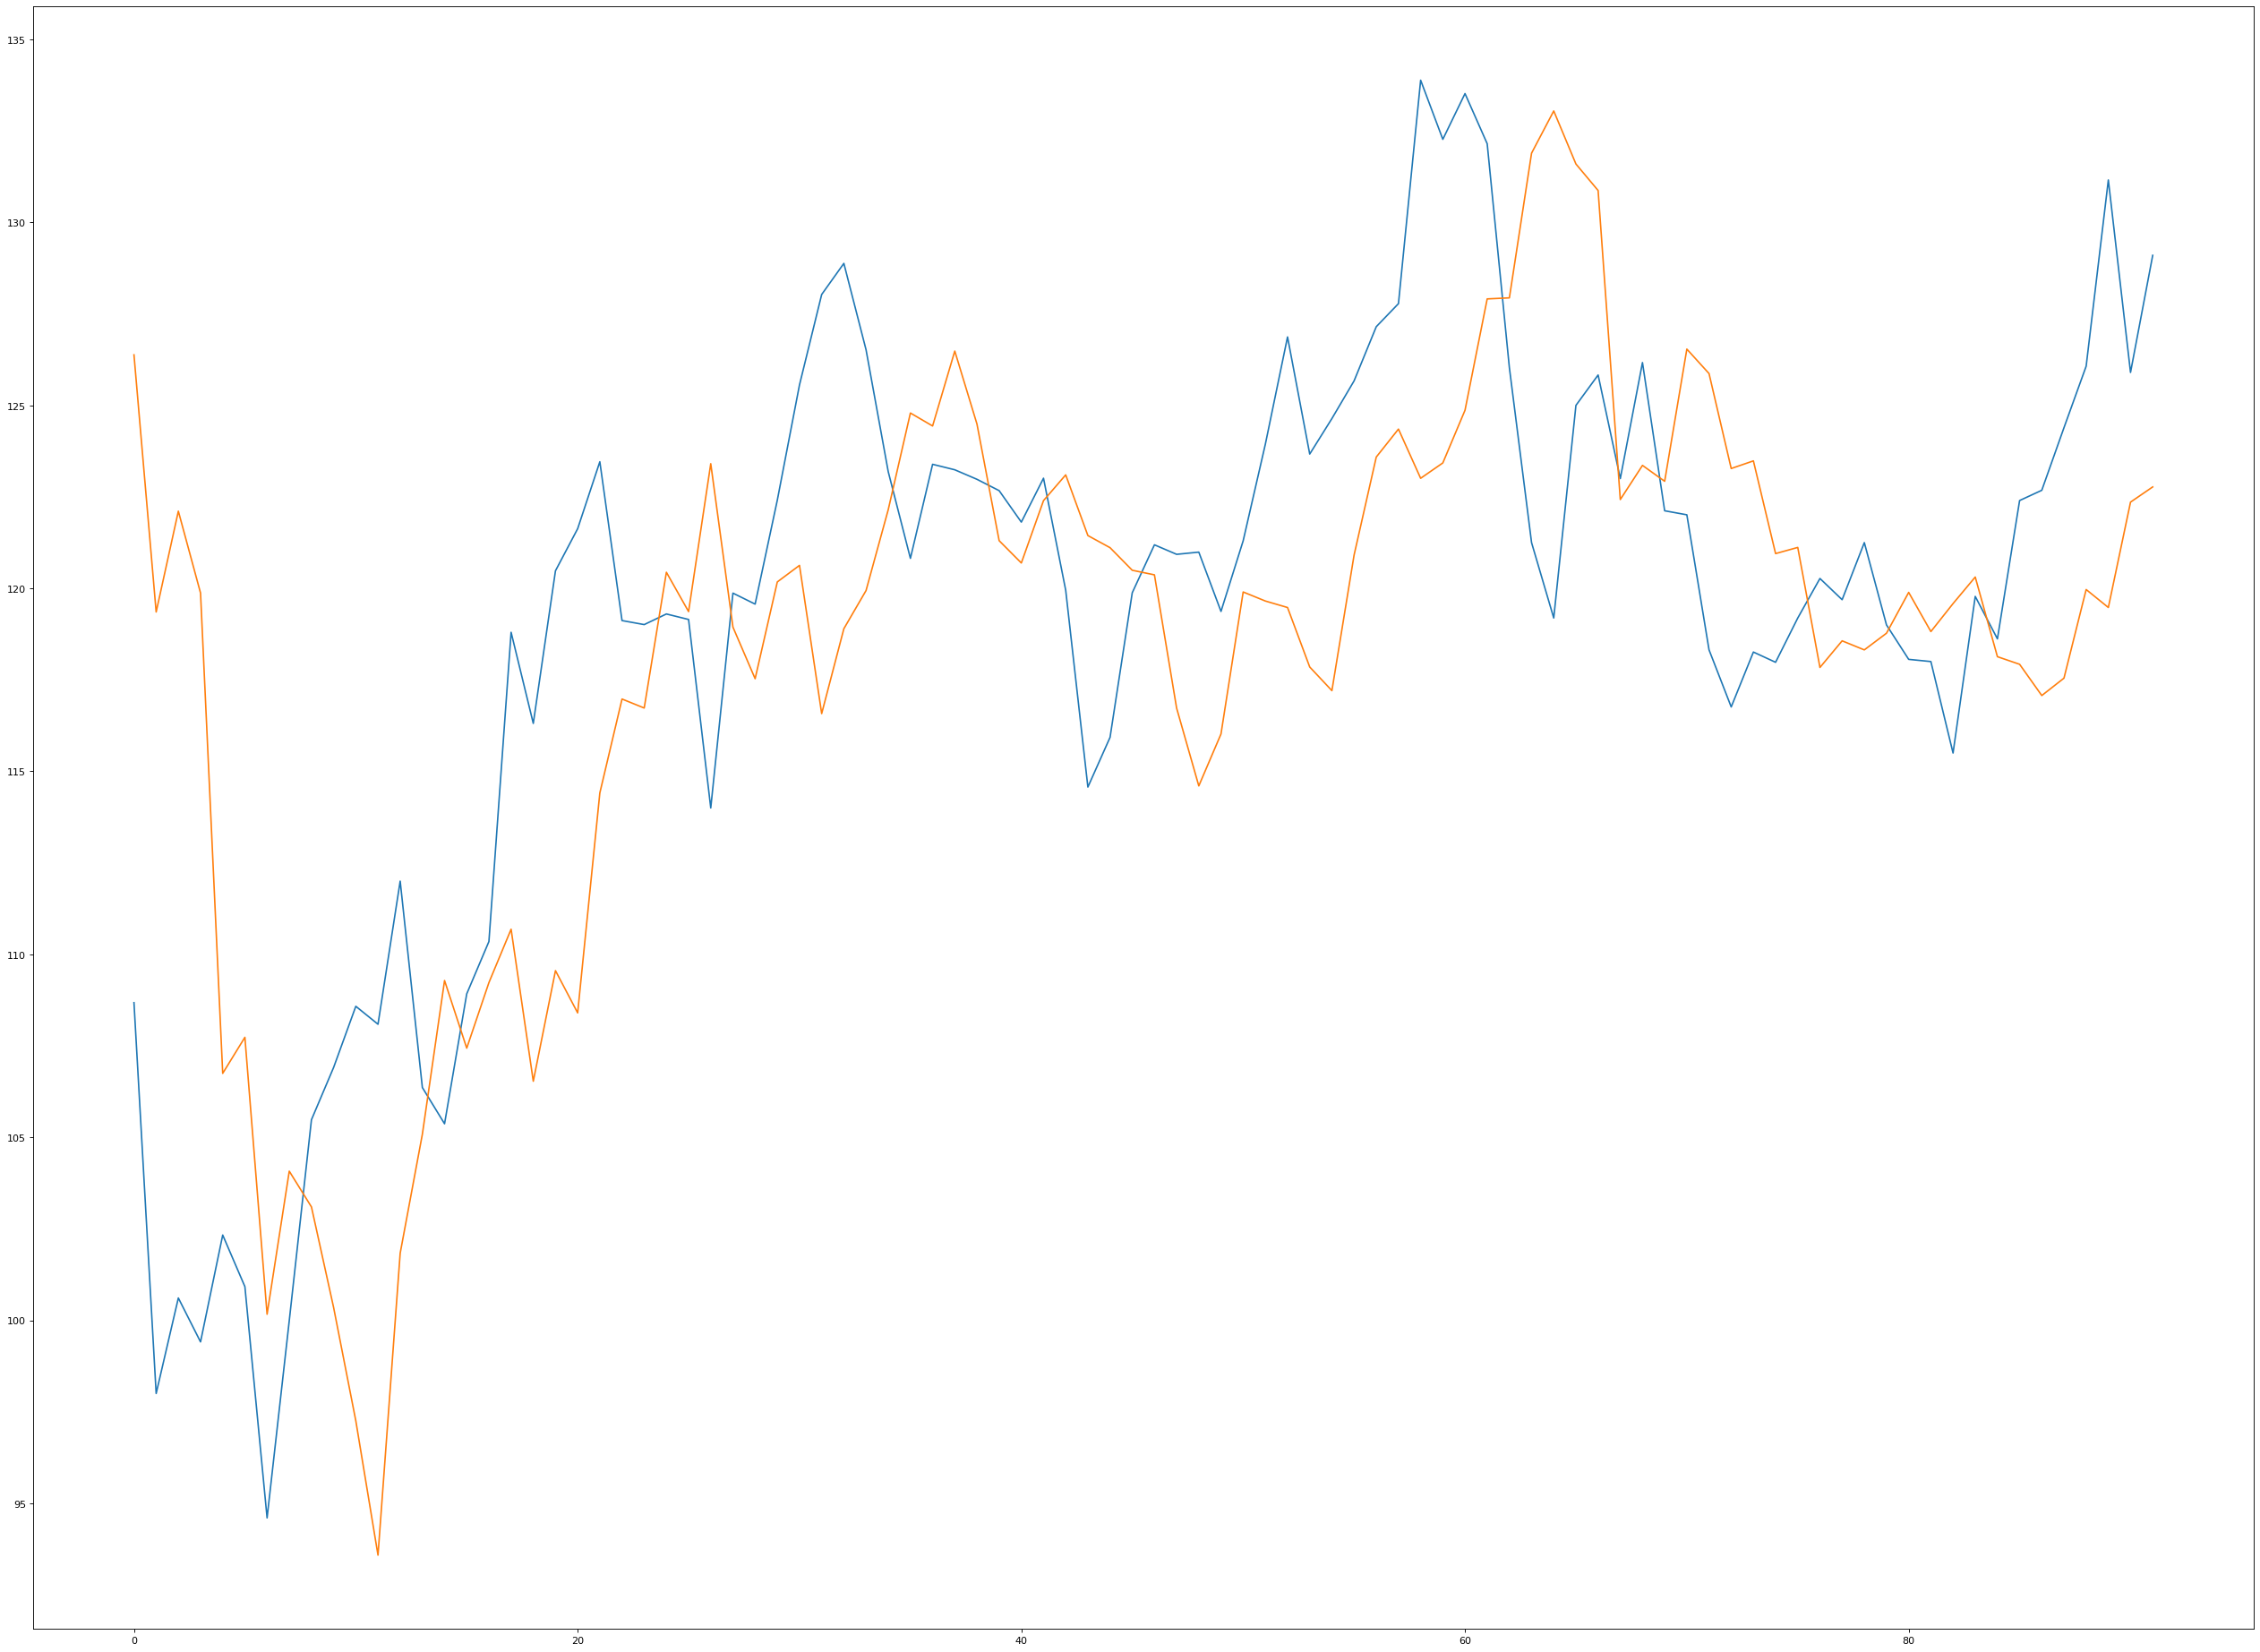

In [33]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), unscaled_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Actual week + prediction of next week (10 days)

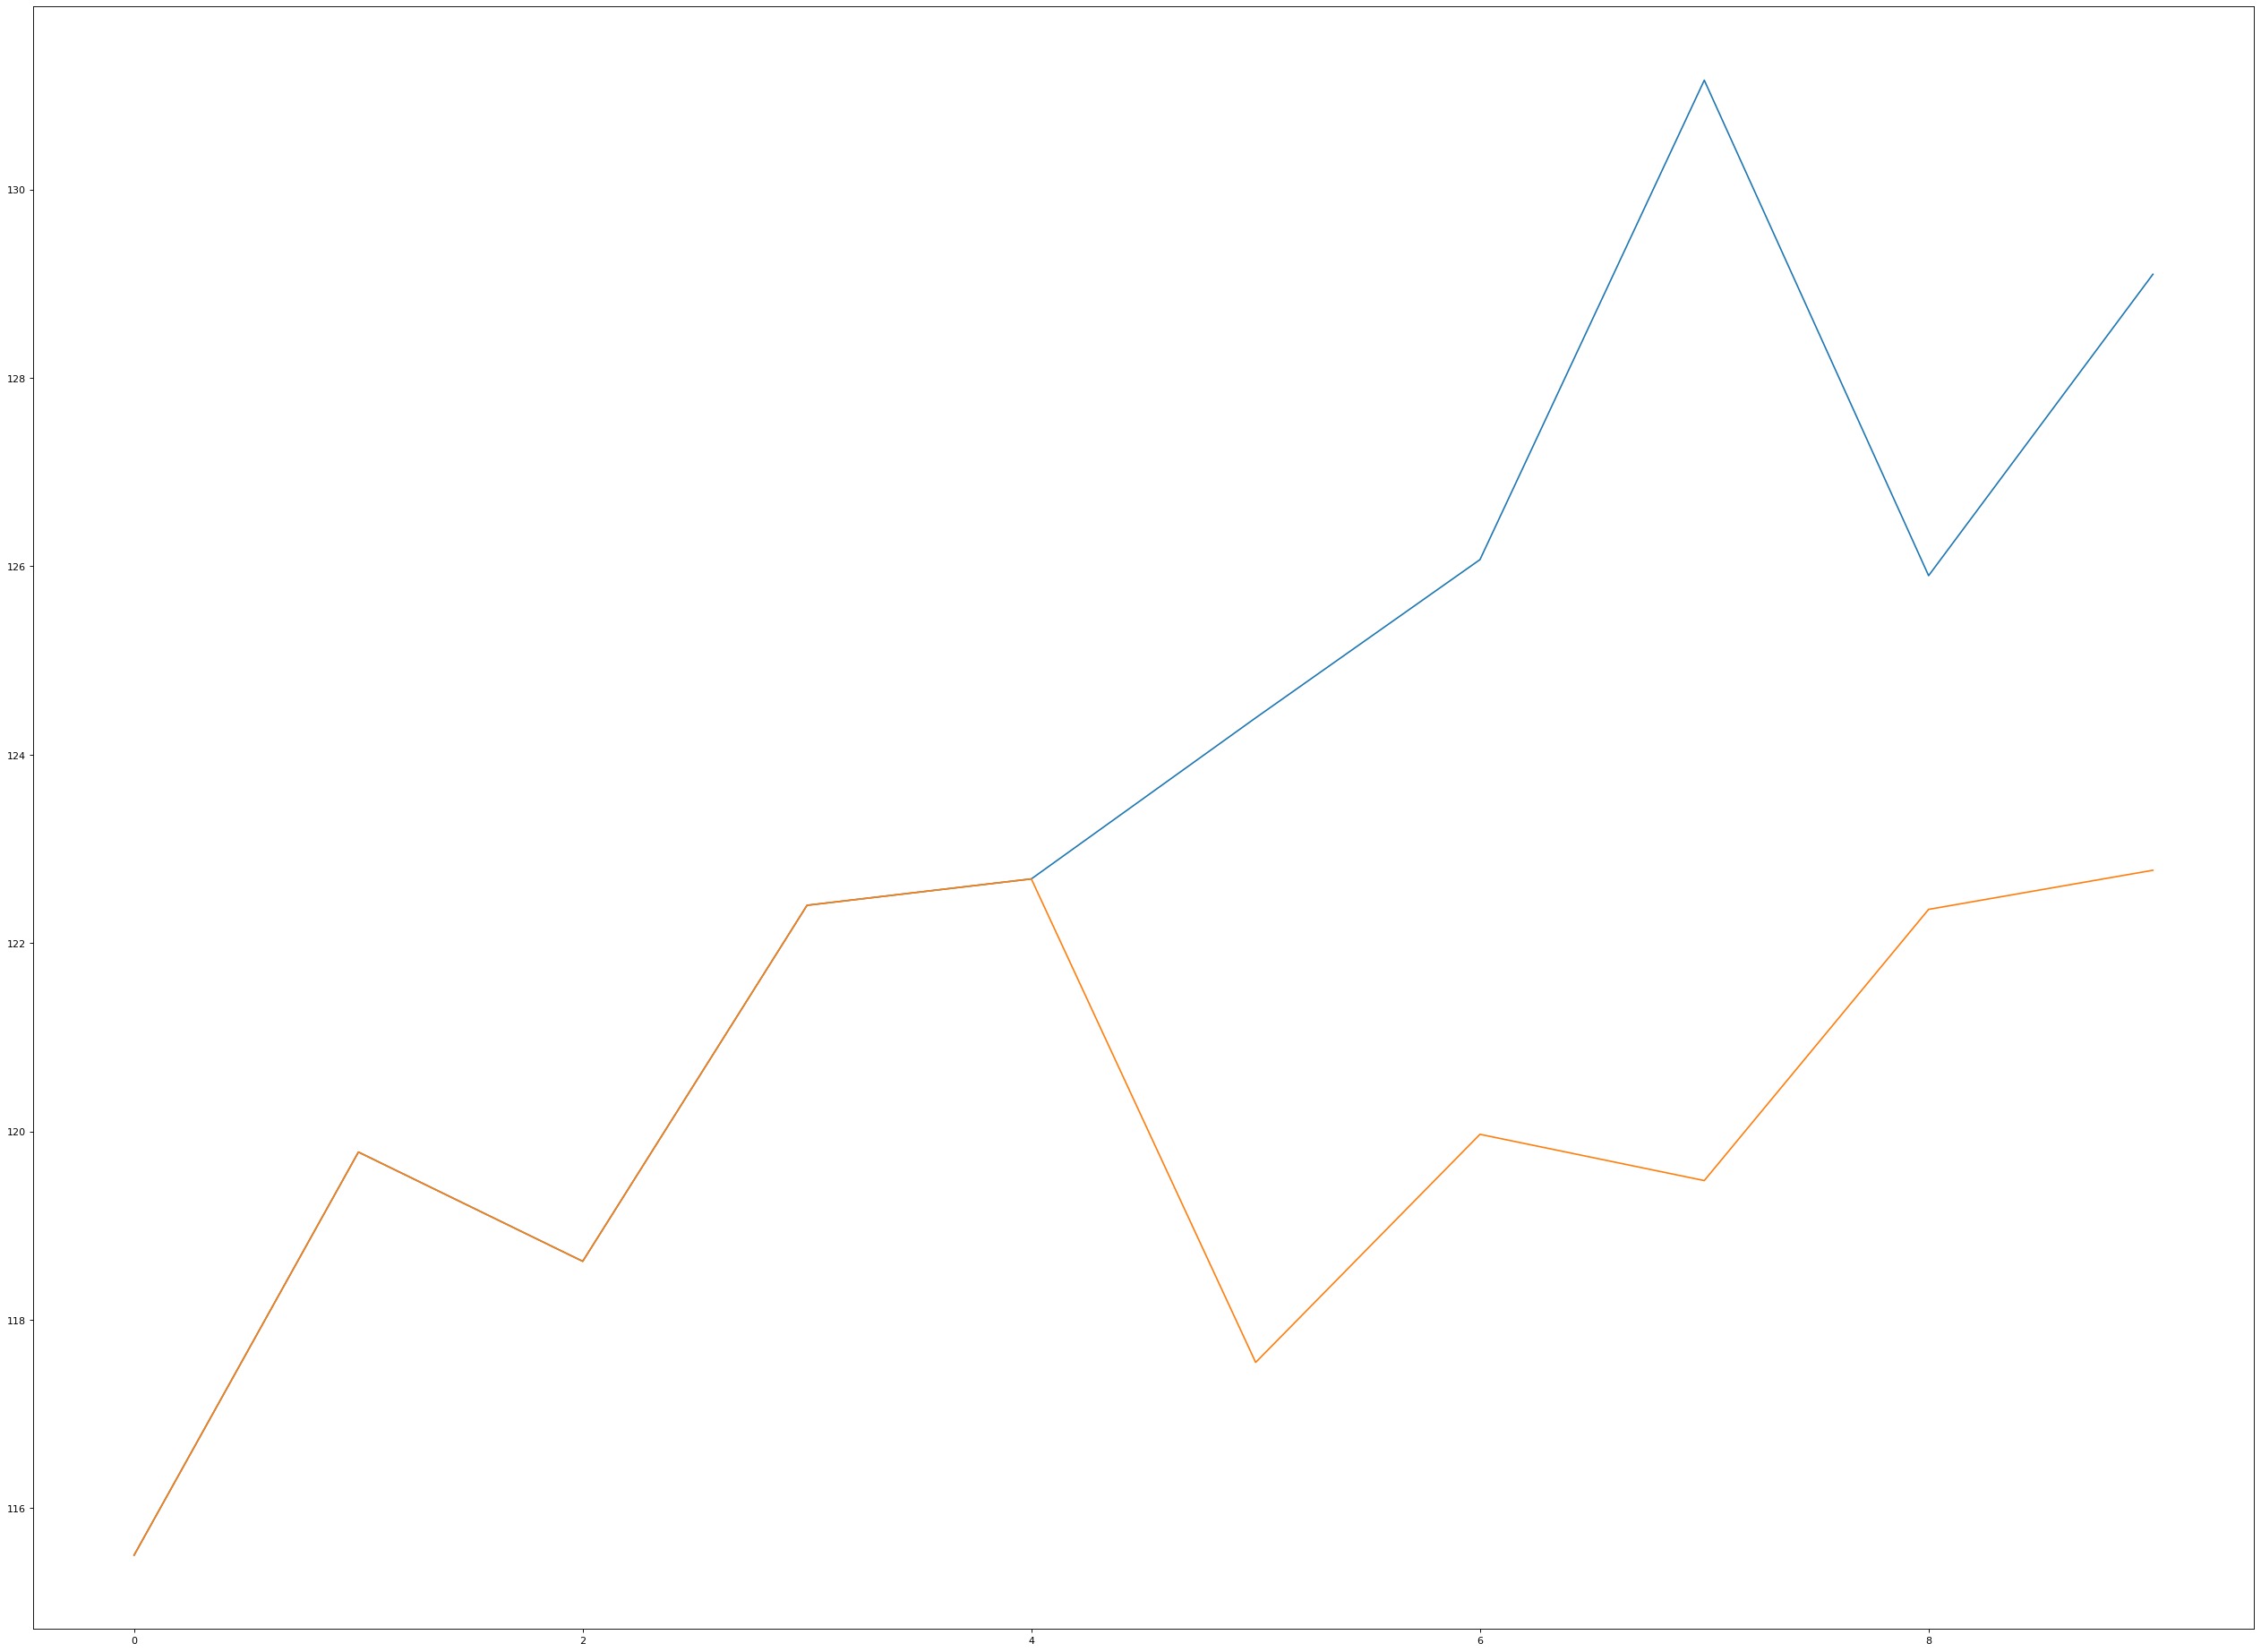

In [34]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(10), unscaled_y_test[-10:])
plt.plot(range(10), np.append(unscaled_y_test[-10:-5], predicted_y_test[-5:]))
plt.show()